# Project 4 : West Nile Virus Classification

# Contents

In this notebook, we will be covering the following:

1. [Introduction](#Introduction)
2. [Data Cleaning, EDA and Feature Engineering](#Data_Cleaning,_EDA_and_Feature_Engineering)


# Introduction

## Problem Statement

According to the [CDC]( https://www.cdc.gov/westnile/index.html#:~:text=About%201%20in%205%20people,pants%20to%20prevent%20mosquito%20bites), West Nile virus (WNV) is the leading cause of mosquito-borne disease in the continental United States. It is acknowledged as the leading cause of mosquito-borne disease in the continental United States. According to the CDC, 1 in 5 people who are infected develop a fever and other symptoms, while 1 out of 150 infected people develop a serious, sometimes fatal, illness. 

In Illinois, West Nile virus was [first identified in September 2001](https://dph.illinois.gov/topics-services/diseases-and-conditions/west-nile-virus.html) when laboratory tests confirmed its presence in two dead crows found in the Chicago area. The following year, the state's first human cases and deaths from West Nile disease were recorded and all but two of the state's 102 counties eventually reported a positive human, bird, mosquito or horse. By the end of 2002, Illinois had counted more human cases (884) and deaths (64) than any other state in the United States.

To date, there have been no licensed vaccines for humans to prevent or treat WNV, although there are vaccines developed and approved for use in [horses](https://www.niaid.nih.gov/diseases-conditions/wnv-vaccines#:~:text=Currently%2C%20there%20is%20no%20licensed,approved%20for%20use%20in%20horses.) in 2005.

In view of this, our project aims to predict occurrence of WNV given time, location, and mosquito species. This will help the City of Chicago and Chicago Department of Public Health (CDPH) more efficiently allocate resources towards preventing transmission of this potentially deadly virus. 

We will also aim to determine where and when to deploy pesticides throughout the city, to maximise pesticide effectiveness and minimise spending.


# Data Cleaning, EDA and Feature Engineering

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import math
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.ticker as mticker

import warnings
warnings.filterwarnings("ignore")

import time

In [2]:
# Import data
train = pd.read_csv('../assets/train.csv')
test = pd.read_csv('../assets/test.csv')
weather = pd.read_csv('../assets/weather.csv')
spray = pd.read_csv('../assets/spray.csv')

## Train Data

We will start with a function to explore null values, duplicates, datatypes and convert our column names to lowercase and convert dates to datetime format.

In [3]:
# Function to explore null values, duplicates and datatypes, convert time datatype, lowercase columns
def explore(data):
# Converting Date to datetime
    data['Date'] = pd.to_datetime(data['Date'])
    print(data.info())
# Lowercase columns
    data.columns = [i.lower() for i in data.columns]
# Null values
    for col in data.columns:
        if data[col].isnull().sum() != 0:
            print(f'{col} column has {data[col].isnull().sum()} null values.')
        else:
            print(f'{col} column has no null values.')
 
        # Duplicate values
    print(f'{data[data.duplicated(keep = False)].shape[0]} number of duplicated rows.')

    return data


In [4]:
explore(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), ob

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos,wnvpresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,"5100 West 72nd Street, Chicago, IL 60638, USA",CULEX PIPIENS/RESTUANS,51,W 72ND ST,T035,"5100 W 72ND ST, Chicago, IL",41.763733,-87.742302,8,6,1
10502,2013-09-26,"5800 North Ridge Avenue, Chicago, IL 60660, USA",CULEX PIPIENS/RESTUANS,58,N RIDGE AVE,T231,"5800 N RIDGE AVE, Chicago, IL",41.987280,-87.666066,8,5,0
10503,2013-09-26,"1700 North Ashland Avenue, Chicago, IL 60622, USA",CULEX PIPIENS/RESTUANS,17,N ASHLAND AVE,T232,"1700 N ASHLAND AVE, Chicago, IL",41.912563,-87.668055,9,1,0
10504,2013-09-26,"7100 North Harlem Avenue, Chicago, IL 60631, USA",CULEX PIPIENS/RESTUANS,71,N HARLEM AVE,T233,"7100 N HARLEM AVE, Chicago, IL",42.009876,-87.807277,9,5,0


No null values. However there are 1062 duplicates, which we think might be because of the way the test results were organized. When the number of mosquitoes exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitoes are capped at 50. This would mean that if an area has 100 or more mosquitoes, there will be duplicates.

### Mosquito Species

In [5]:
# Add year, month, week and day of week features

train['year'] = train['date'].apply(lambda x: x.year)
train['month'] = train['date'].apply(lambda x: x.month)
train['week'] = train['date'].apply(lambda x: x.week)
train['dayofweek'] = train['date'].apply(lambda x: x.dayofweek)

,species,nummosquitos,wnvpresent,sample_count
0,CULEX PIPIENS/RESTUANS,66268,262,4752
1,CULEX PIPIENS,44671,240,2699
2,CULEX RESTUANS,23431,49,2740
3,CULEX ERRATICUS,7,0,1
4,CULEX SALINARIUS,145,0,86
5,CULEX TARSALIS,7,0,6
6,CULEX TERRITANS,510,0,222


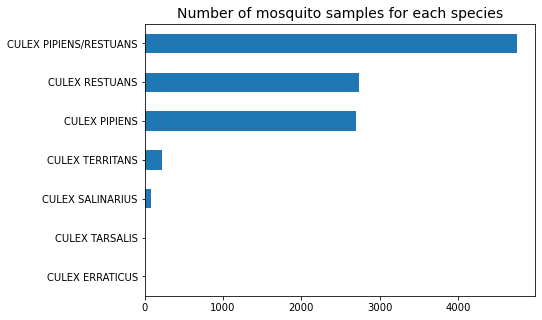

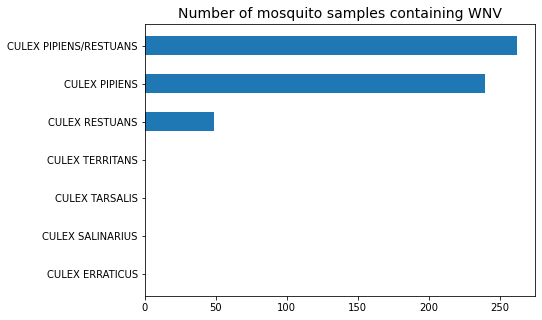

In [6]:
# how many samples containing WNV for each species?

mos_wnv = train[['species', 'nummosquitos', 'wnvpresent']].groupby(by='species').sum()

mos_wnv = mos_wnv.sort_values(by='wnvpresent', ascending = False)
mos_wnv.reset_index(inplace=True)

# creating sample count dataframe
sample_count = train["species"].value_counts()
sample_count = pd.DataFrame(sample_count)
sample_count.reset_index(inplace=True)
sample_count.rename(columns = {'index':'species',
                    'species':'sample_count'},
                   inplace=True)

# merging WNV df with sample count df
wnv_occurance = pd.merge(mos_wnv,sample_count)
display(wnv_occurance)


# --- Plots for vizualisation ---

# Plot: Number of mosquito samples for each species
train['species'].value_counts(ascending=True).plot(kind='barh', figsize=(7,5))
plt.title('Number of mosquito samples for each species', fontsize=14);

# Plot: How many samples containing WNV for each species?
mos_wnv = mos_wnv.sort_values(by='wnvpresent', ascending=True)
plt.figure(figsize=(7,5))
plt.barh(mos_wnv['species'], mos_wnv['wnvpresent'], height=0.5)
plt.title('Number of mosquito samples containing WNV', fontsize=14);

The above table shows the number of sample counts for each species of mosquito, as well as how many of these samples contain WNV. We can immediately tell that the 2 most common species of mosquitoes are the Culex Pipiens and Culex Restuans, and samples containing both these species are the most common in Chicago. They are also the only 2 species that carry WNV.

The table also shows us that, the total number of Culex Pipiens is almost 2 times more than the Culex Restuans. However, they have lesser sample counts, which may suggest that the population of Culex Pipiens is higher in each sample/cluster. There were much more Culex Pipiens samples that are WNV-present.

Overall, Culex Pipiens could be considered the most dangerous specie due to having the highest proportion of WNV-present samples.

### Presence of WNV

Text(0, 0.5, 'WNV occurrences')

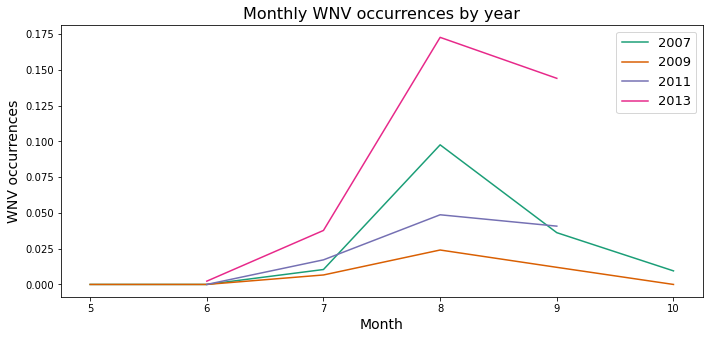

In [7]:
plt.figure(figsize=(11.5,5))
sns.lineplot(data = train, x='month', y='wnvpresent', hue='year', ci = None, palette='Dark2')
plt.legend(fontsize = 13)
plt.title('Monthly WNV occurrences by year', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('WNV occurrences',fontsize=14)

From the lines in the plot above, the year with the highest WNV occurences is 2013, followed by 2007. It is generally quite low in the years 2009 and 2011.

A pattern can also be observed here. WNV occurences start at around June, and rise rapidly from July onwards. August is the peak month with the most WNV occurence for all years. Thereafter, the occurences start to reduce through September and cease from October.

June to August are the summer months in Chicago, when it is the [hottest](https://weatherspark.com/y/14091/Average-Weather-in-Chicago-Illinois-United-States-Year-Round#:~:text=The%20hottest%20month%20of%20the,high%20of%2033%C2%B0F) in the year. Our first guess would be that the temperature during the summer season exacerbated the breeding of mosquitoes and which in turn increase the number of WNV occurences. We will next explore the number of mosquitoes and number of WNV cases and see if the relationship is true.

### Number of mosquitoes vs number of WNV cases

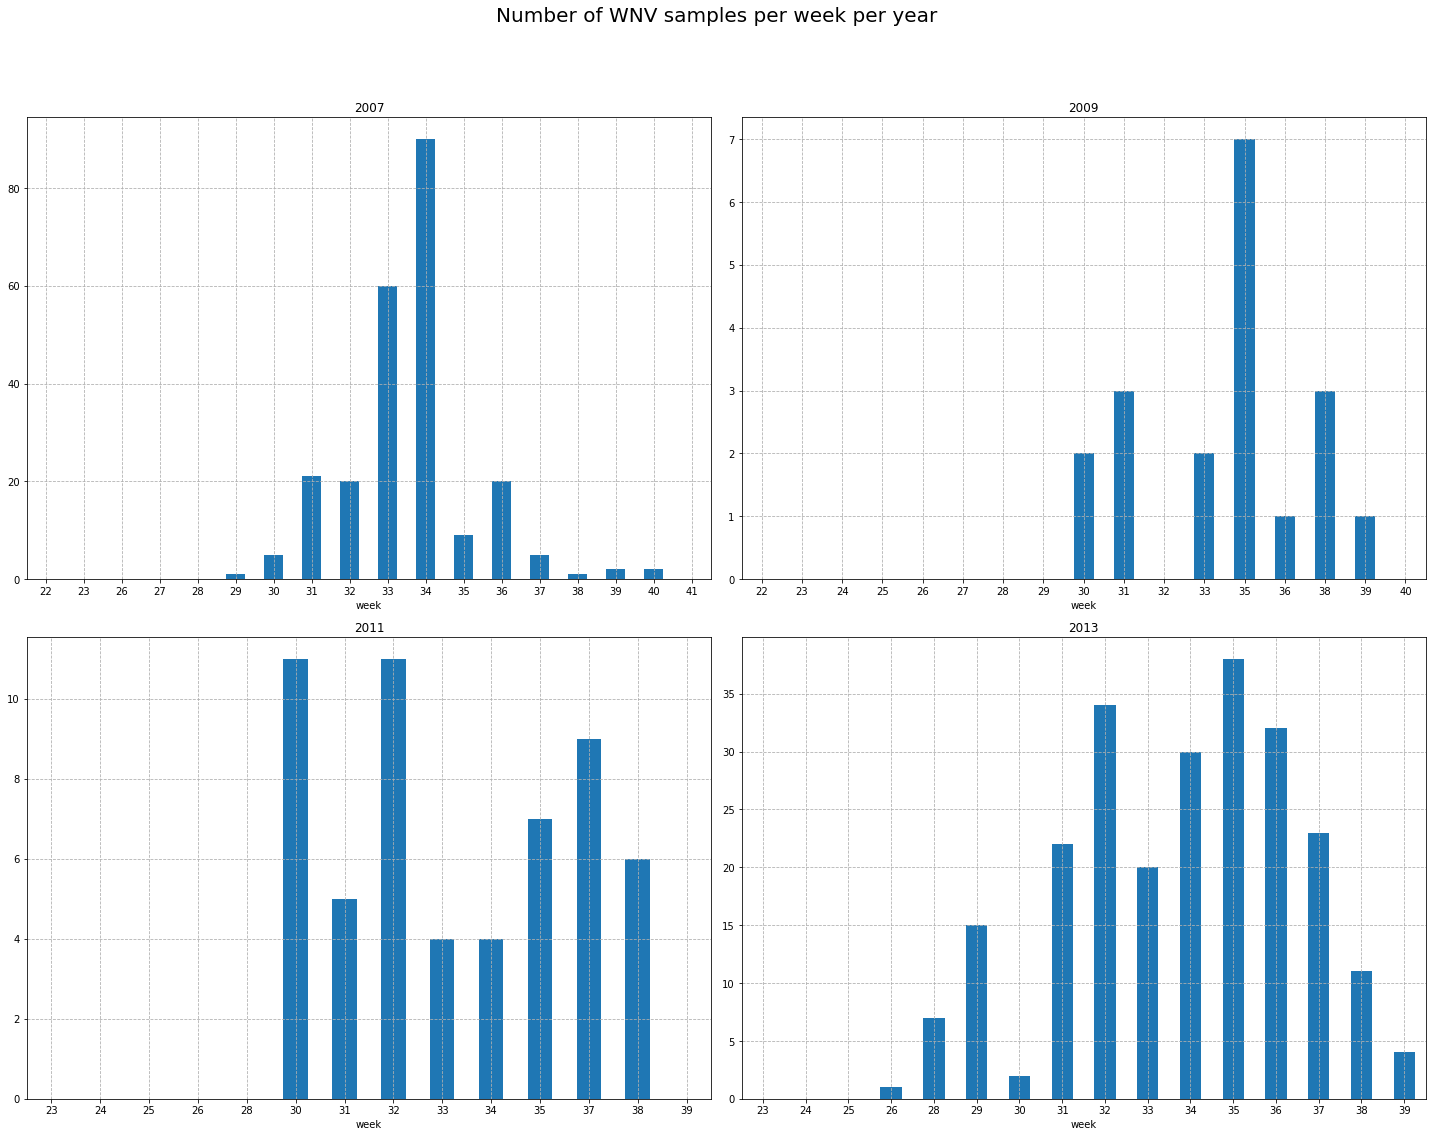

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax = ax.ravel()
plt.suptitle('Number of WNV samples per week per year', fontsize=20, y=1.05)
for i, y in enumerate(train['year'].unique()):
    train[train['year']==y].groupby(['week'])['wnvpresent'].sum().plot.bar(ax=ax[i])
    ax[i].set_title(y)
    ax[i].tick_params(axis='x', labelrotation=0)
    ax[i].grid(linestyle='--')
plt.tight_layout()

The above 4 bar charts for years 2007, 2009, 2011 and 2013 show a much more in-depth visual than the line plot we discussed earlier, as the number of WNV cases are split per week instead of per month. This in-depth analysis shows us that WNV cases appear from around weeks 30 to 39. Years 2007 and 2013 have extended weeks and a lot more cases as compared to years 2009 and 2011.

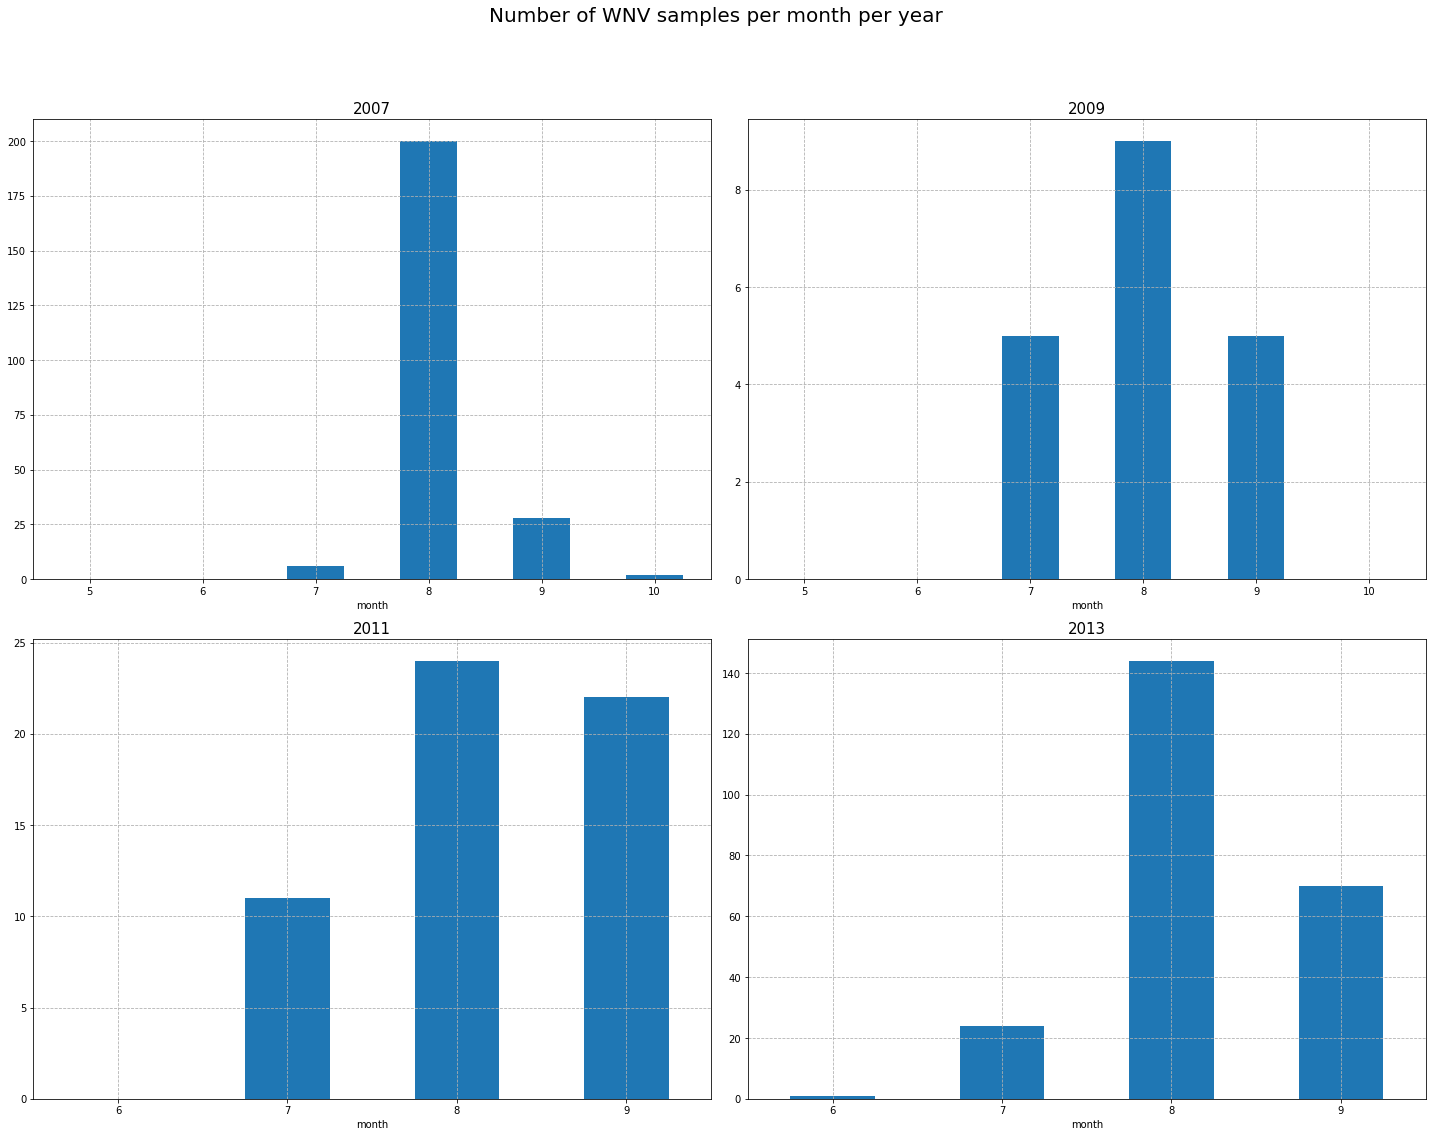

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax = ax.ravel()
plt.suptitle('Number of WNV samples per month per year', fontsize=20, y=1.05)
for i, y in enumerate(train['year'].unique()):
    train[train['year']==y].groupby(['month'])['wnvpresent'].sum().plot.bar(ax=ax[i])
    ax[i].set_title(y, fontsize = 15)
    ax[i].tick_params(axis='x', labelrotation=0)
    ax[i].grid(linestyle='--')
plt.tight_layout()

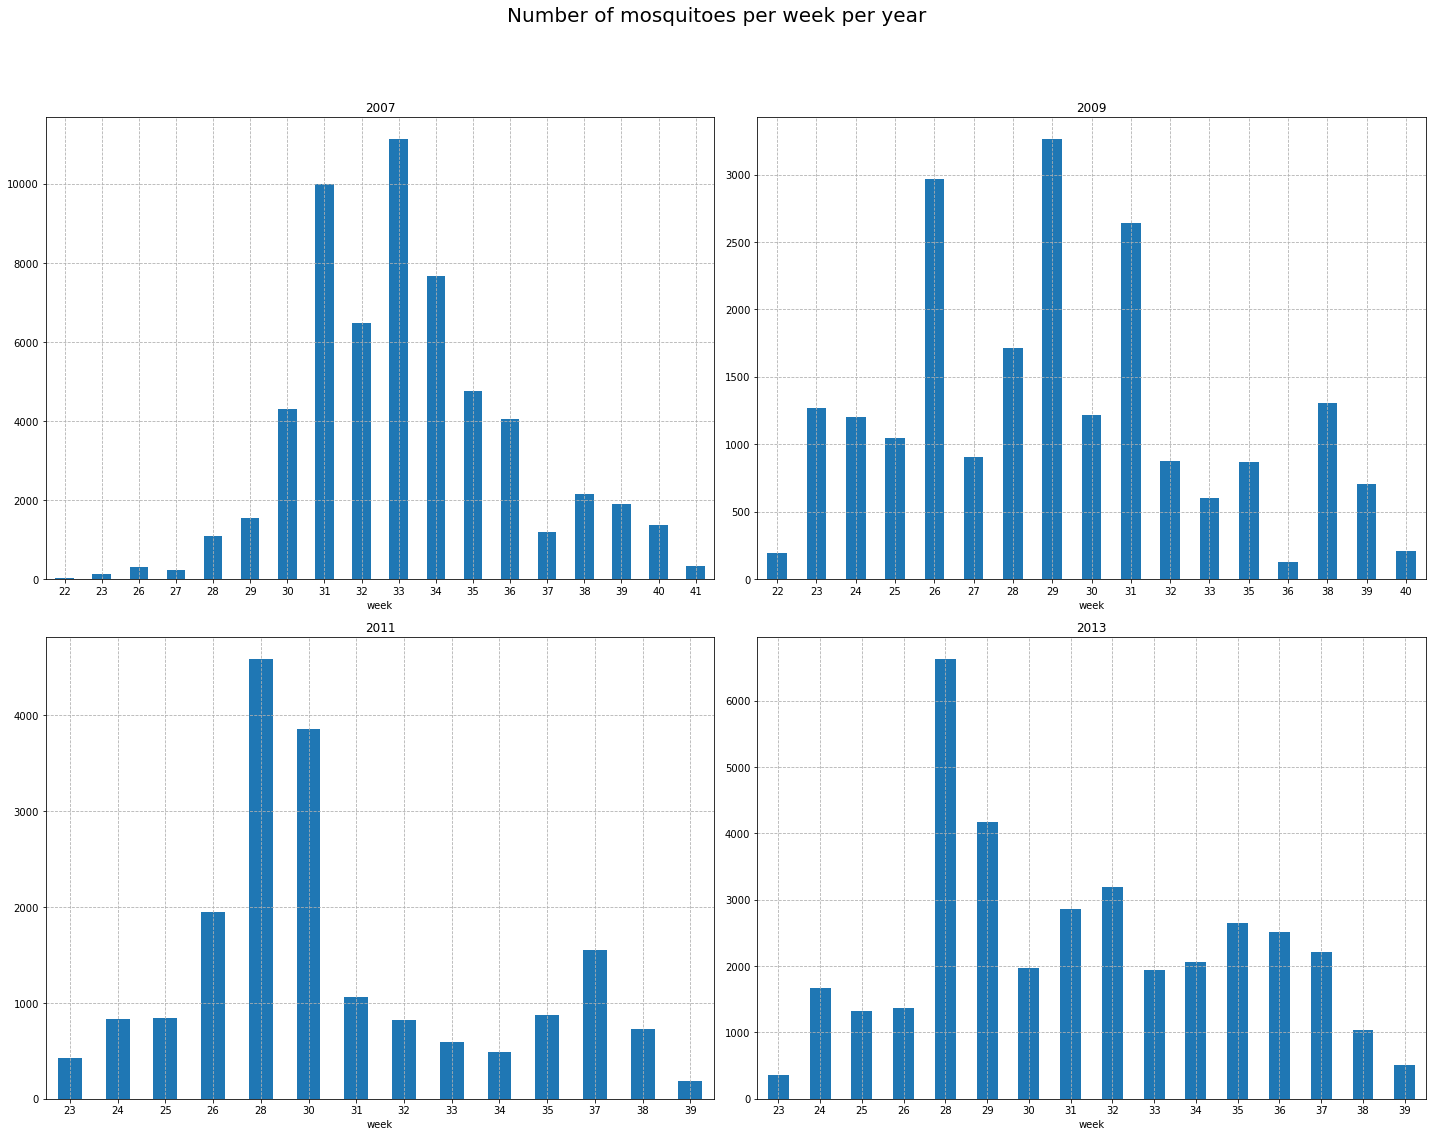

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
ax = ax.ravel()
plt.suptitle('Number of mosquitoes per week per year', fontsize=20, y=1.05)
for i, y in enumerate(train['year'].unique()):
    train[train['year']==y].groupby(['week'])['nummosquitos'].sum().plot.bar(ax=ax[i])
    ax[i].set_title(y)
    ax[i].tick_params(axis='x', labelrotation=0)
    ax[i].grid(linestyle='--')
plt.tight_layout()

Above plots show bar charts for number of mosquitoes collected from samples per week for years 2007, 2009, 2011 and 2013. It seems like the mosquitoes start to appear at week 23 (start of June) all the way to week 40 (October). This length of time is longer than the WNV cases detected from each sample.

In addition, high number of mosquitoes per week generally happens **earlier** than high number of WNV cases. Most years have the highest number of mosquitoes at week 28-29, while peak WNV cases are at around week 34-35 (excluding year 2011 with peak WNV at week 30).

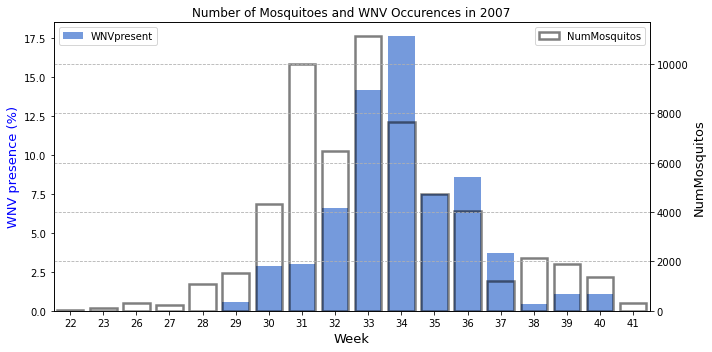

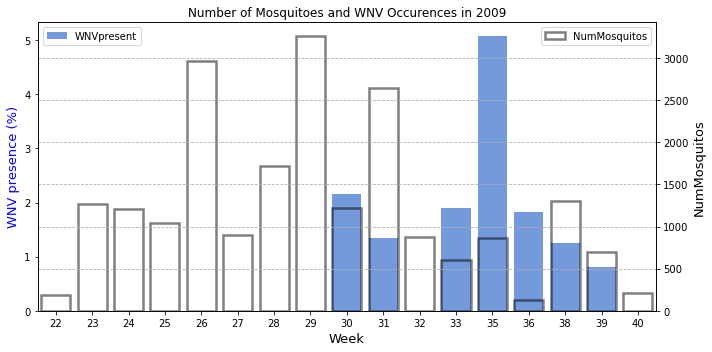

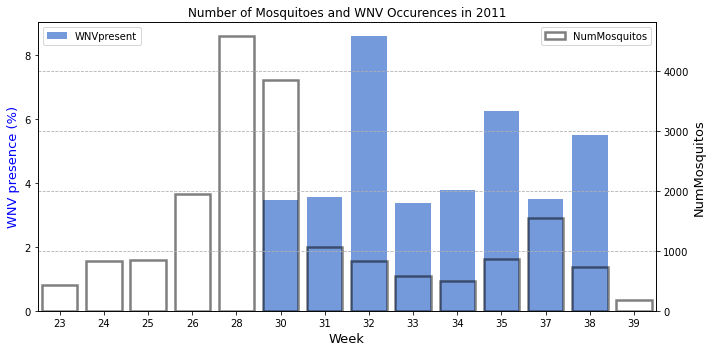

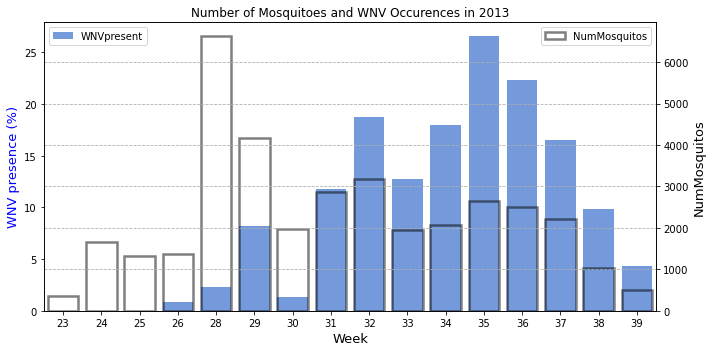

In [11]:
for yr in train['year'].unique():
    fig, ax1 = plt.subplots(figsize=(10,5))
       
    # bar plot for WNV presence
    kwargs = {'alpha': 0.5}
    sns.barplot(x = train[train['year'] == yr]['week'], y = train[train['year'] == yr]['wnvpresent']*100,
                ci=None, color='cornflowerblue', label='WNVpresent', ax=ax1)
    ax1.set_xlabel('Week', fontsize=13)
    ax1.set_ylabel('WNV presence (%)', fontsize=13, color='blue')
    ax1.set_xticklabels(ax1.get_xticklabels());
    ax1.legend(loc=2)
    
    # setting up dataframe for plotting
    no_mosquito = train[train['year'] == yr].groupby(['week'])['nummosquitos'].sum()
    df_no_mosquito = pd.DataFrame(no_mosquito)

    # bar plot for NumMosquitos
    ax2 = ax1.twinx()
    sns.barplot(x = df_no_mosquito.index, y = df_no_mosquito['nummosquitos'],
                ci=None, color='black', linewidth=2.5, label='NumMosquitos', ax=ax2, **kwargs, fill=False)
    ax2.set_ylabel('NumMosquitos', fontsize=13, color='black')
    ax2.legend(loc=1)

    plt.title(f'Number of Mosquitoes and WNV Occurences in {yr}')
    
    plt.grid(linestyle='--')
    fig.tight_layout()

Above bar plots combine number of mosquitoes and number of WNV cases per week per year. It seems like high proportion of WNV cases and high number of mosquitoes do not happen together. High proportion of WNV cases happen much later, at weeks 30 to 39. High number of mosquitoes peak earlier at around week 28 to 29.

This pattern is hard to explain, as initial thoughts would be for both number of mosquitoes and WNV occurences to be highly correlated. We will explore other datasets to see if we can make sense of this pattern.

### Preliminary preprocessing function for train and test

This preliminary preprocessing function will ready our train dataset for merging with our weather dataset. More EDA will be done after merging.

The cleaning process is as follows:

- All column names will be converted to lower case
- 'date' column will be converted to datetime type
- 'year', 'month', 'week', and 'dayofweek' will be extracted from 'date' column
- 'species' will be converted to ordinal numeric: species with the potential to carry WNV will be 1, species with no potential to carry WNV will be 0
- 'block','street','trap','addressnumberandstreet','addressaccuracy','nummosquitos' will be dropped as they will no longer be necessary for EDA

In [12]:
# train = pd.read_csv('../data/train.csv')

train = pd.read_csv('../assets/train.csv')

In [13]:
def preprocess_train(train):
    # lowercase all column names
    train.columns = [i.lower() for i in train.columns]
    
    # Converting Date to datetime
    train['date'] = pd.to_datetime(train['date'])
    
    # Add year, month, week and day of week features
    train['year'] = train['date'].apply(lambda x: x.year)
    train['month'] = train['date'].apply(lambda x: x.month)
    train['week'] = train['date'].apply(lambda x: x.week)
    train['dayofweek'] = train['date'].apply(lambda x: x.dayofweek)
    
    # changing 'species' feature
    # WNV-carrier mosquito species = 1
    # Non-WNV mosquito species = 0
    # WNV_carrier_dict = {'CULEX PIPIENS/RESTUANS': 1,
    #                    'CULEX RESTUANS': 1,
    #                    'CULEX PIPIENS': 1,
    #                    'CULEX TERRITANS': 0,
    #                    'CULEX SALINARIUS': 0,
    #                    'CULEX TARSALIS': 0,
    #                    'CULEX ERRATICUS': 0}
    
    # train['species'] = train['species'].map(WNV_carrier_dict)
    
    # dropping columns
    to_drop = ['block','street','trap','addressnumberandstreet','addressaccuracy','nummosquitos','address']
    
    train.drop(to_drop, axis = 1, inplace = True)
    
    return train

In [14]:
def preprocess_test(test):
    # lowercase all column names
    test.columns = [i.lower() for i in test.columns]
    
    # Converting Date to datetime
    test['date'] = pd.to_datetime(test['date'])
    
    # Add year, month, week and day of week features
    test['year'] = test['date'].apply(lambda x: x.year)
    test['month'] = test['date'].apply(lambda x: x.month)
    test['week'] = test['date'].apply(lambda x: x.week)
    test['dayofweek'] = test['date'].apply(lambda x: x.dayofweek)
    
    # changing 'species' feature
    # WNV-carrier mosquito species = 1
    # Non-WNV mosquito species = 0
    # WNV_carrier_dict = {'CULEX PIPIENS/RESTUANS': 1,
    #                    'CULEX RESTUANS': 1,
    #                    'CULEX PIPIENS': 1,
    #                    'CULEX TERRITANS': 0,
    #                    'CULEX SALINARIUS': 0,
    #                    'CULEX TARSALIS': 0,
    #                    'CULEX ERRATICUS': 0}
    
    # test['species'] = test['species'].map(WNV_carrier_dict)
    
    # dropping columns
    to_drop = ['block','street','trap','addressnumberandstreet','addressaccuracy','address']
    
    test.drop(to_drop, axis = 1, inplace = True)
    
    return test

In [15]:
preprocess_train(train)
train

,date,species,latitude,longitude,wnvpresent,year,month,week,dayofweek
0,2007-05-29,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,0,2007,5,22,1
1,2007-05-29,CULEX RESTUANS,41.954690,-87.800991,0,2007,5,22,1
2,2007-05-29,CULEX RESTUANS,41.994991,-87.769279,0,2007,5,22,1
3,2007-05-29,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,0,2007,5,22,1
4,2007-05-29,CULEX RESTUANS,41.974089,-87.824812,0,2007,5,22,1
...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,CULEX PIPIENS/RESTUANS,41.763733,-87.742302,1,2013,9,39,3
10502,2013-09-26,CULEX PIPIENS/RESTUANS,41.987280,-87.666066,0,2013,9,39,3
10503,2013-09-26,CULEX PIPIENS/RESTUANS,41.912563,-87.668055,0,2013,9,39,3
10504,2013-09-26,CULEX PIPIENS/RESTUANS,42.009876,-87.807277,0,2013,9,39,3


In [16]:
preprocess_test(test)
test

,id,date,species,latitude,longitude,year,month,week,dayofweek
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,2008,6,24,2
1,2,2008-06-11,CULEX RESTUANS,41.954690,-87.800991,2008,6,24,2
2,3,2008-06-11,CULEX PIPIENS,41.954690,-87.800991,2008,6,24,2
3,4,2008-06-11,CULEX SALINARIUS,41.954690,-87.800991,2008,6,24,2
4,5,2008-06-11,CULEX TERRITANS,41.954690,-87.800991,2008,6,24,2
...,...,...,...,...,...,...,...,...,...
116288,116289,2014-10-02,CULEX SALINARIUS,41.925652,-87.633590,2014,10,40,3
116289,116290,2014-10-02,CULEX TERRITANS,41.925652,-87.633590,2014,10,40,3
116290,116291,2014-10-02,CULEX TARSALIS,41.925652,-87.633590,2014,10,40,3
116291,116292,2014-10-02,UNSPECIFIED CULEX,41.925652,-87.633590,2014,10,40,3


In [17]:
test['species']

0         CULEX PIPIENS/RESTUANS
1                 CULEX RESTUANS
2                  CULEX PIPIENS
3               CULEX SALINARIUS
4                CULEX TERRITANS
                   ...          
116288          CULEX SALINARIUS
116289           CULEX TERRITANS
116290            CULEX TARSALIS
116291         UNSPECIFIED CULEX
116292           CULEX ERRATICUS
Name: species, Length: 116293, dtype: object

## Weather Data

In [18]:
explore(weather)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,codesum,depth,water1,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,M,34,42,20,0,...,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,...,,0,M,0.0,0.00,29.34,30.09,5.1,24,5.5
2941,2,2014-10-30,53,37,45,M,35,42,20,0,...,RA,M,M,M,T,29.41,30.10,5.9,23,6.5
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,...,RA SN,0,M,0.1,0.03,29.49,30.20,22.6,34,22.9


We will be splitting our 'date' column into by year, month and week of the year for clearer analysis.

In [19]:
# Splitting date columns to 'year', 'month', 'weekofyear', ' dayofweek'.

weather['year'] = weather['date'].apply(lambda x:x.year)
weather['month'] = weather['date'].apply(lambda x:x.month)
weather['week'] = weather['date'].apply(lambda x:x.weekofyear)
weather['dayofweek'] = weather['date'].apply(lambda x: x.dayofweek)

We will include a column for 'yearweek' for ease of groupby.

In [20]:
def year_week(row):
    week = row['week']
    year = row['year']
    row['yearweek'] = f'{year}{week}'
    row['yearweek'] = int(row['yearweek'])
    return row
    
train = train.apply(year_week, axis=1)
weather = weather.apply(year_week, axis=1)


In [21]:
weather

,station,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,week,dayofweek,yearweek
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,29.10,29.82,1.7,27,9.2,2007,5,18,1,200718
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,29.18,29.82,2.7,25,9.6,2007,5,18,1,200718
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,29.38,30.09,13.0,4,13.4,2007,5,18,2,200718
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,29.44,30.08,13.3,2,13.4,2007,5,18,2,200718
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,29.39,30.12,11.7,7,11.9,2007,5,18,3,200718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,M,34,42,20,0,...,29.42,30.07,8.5,29,9.0,2014,10,44,2,201444
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,...,29.34,30.09,5.1,24,5.5,2014,10,44,3,201444
2941,2,2014-10-30,53,37,45,M,35,42,20,0,...,29.41,30.10,5.9,23,6.5,2014,10,44,3,201444
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,...,29.49,30.20,22.6,34,22.9,2014,10,44,4,201444


### Imputation of 'M', 'T' and '-' values

Upon closer inspection, there were many values which represent missing data like 'M' and '-', and trace, represented by 'T'.

In [22]:
weather.isin(['M']).sum()[weather.isin(['M']).sum() > 0].sort_values(ascending = False)

water1         2944
depart         1472
depth          1472
snowfall       1472
tavg             11
heat             11
cool             11
sealevel          9
wetbulb           4
stnpressure       4
avgspeed          3
preciptotal       2
dtype: int64

In [23]:
weather.isin(['  T']).sum()[weather.isin(['  T']).sum() > 0].sort_values(ascending = False)

preciptotal    318
snowfall        12
dtype: int64

In [24]:
weather.isin(['-']).sum()[weather.isin(['-']).sum() > 0].sort_values(ascending = False)

sunrise    1472
sunset     1472
dtype: int64

As values from 'snowfall', 'depth', 'sealevel' are very small numbers or filled with missing or trace values (very small amount), we will be dropping these columns. We will also be dropping 'water1' due to the entire column being missing data. 'Depart' will also be dropped as values for station 2 are missing and departure of temperature from historical norm is unlikely to affect population of mosquitoes. There are other data that take into account temperature like 'tavg', 'tmin' and 'tmax'.

In [25]:
weather = weather.drop(columns = ['sealevel','depth','snowfall','water1','depart'], axis = 1)

In [26]:
# Imputing missing values for cool, heat and tavg for missing values

def impute_tavg_heat_cool(row):
    # Impute missing values for tavg
    if row['tavg'] == 'M':
        row['tavg'] = round((row['tmax'] + row['tmin']) / 2)
        
    # Impute missing values for Cool and Warm
    if row['cool'] == 'M' or row['heat'] == 'M':
        val = 65 - row['tavg']
        if val < 0: 
            row['cool'] = val
            row['heat'] = 0
        elif val > 0:
            row['cool'] = 0
            row['heat'] = val
        else:
            row['cool'] = row['heat'] = 0
    return row

In [27]:
weather = weather.apply(impute_tavg_heat_cool, axis = 1)

In [28]:
weather.isin(['M']).sum()[weather.isin(['M']).sum() > 0].sort_values(ascending = False)

wetbulb        4
stnpressure    4
avgspeed       3
preciptotal    2
dtype: int64

We will be imputing the remaining 'M' values with corresponding values from the opposite station. (eg if data is missing from station 1, impute with value from station 2, and vice versa).

In [29]:
display(weather[(weather['station'] == 1) & (weather['stnpressure'] == 'M')])
display(weather[(weather['station'] == 2) & (weather['stnpressure'] == 'M')])

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,...,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,year,month,week,dayofweek,yearweek
848,1,2009-06-26,86,69,78,60,M,0,13,0418,...,0.00,M,6.4,4,8.2,2009,6,26,4,200926
2410,1,2013-08-10,81,64,73,57,M,0,8,0454,...,0.00,M,5.3,5,6.5,2013,8,32,5,201332


,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,...,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,year,month,week,dayofweek,yearweek
87,2,2007-06-13,86,68,77,53,62,0,12,-,...,0.00,M,7.0,5,M,2007,6,24,2,200724
2411,2,2013-08-10,81,68,75,55,63,0,10,-,...,0.00,M,6.0,6,7.4,2013,8,32,5,201332


The 4 'M' values for 'stnpressure' will be imputed based on the average of the value from the day before and after from the same station. We then do the same for 'wetbulb', 'avg_speed', and 'preciptotal'.

In [30]:
weather.loc[848,'stnpressure'] = 29.09
weather.loc[2410,'stnpressure'] = 29.32
weather.loc[87,'stnpressure'] = 29.43
weather.loc[2411,'stnpressure'] = 29.38

In [31]:
display(weather.loc[848,'stnpressure']) 
display(weather.loc[2410,'stnpressure'])
display(weather.loc[87,'stnpressure']) 
display(weather.loc[2411,'stnpressure'])

29.09

29.32

29.43

29.38

In [32]:
display(weather[(weather['station'] == 1) & (weather['wetbulb'] == 'M')])
display(weather[(weather['station'] == 2) & (weather['wetbulb'] == 'M')])

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,...,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,year,month,week,dayofweek,yearweek
848,1,2009-06-26,86,69,78,60,M,0,13,0418,...,0.00,29.09,6.4,4,8.2,2009,6,26,4,200926
2410,1,2013-08-10,81,64,73,57,M,0,8,0454,...,0.00,29.32,5.3,5,6.5,2013,8,32,5,201332
2412,1,2013-08-11,81,60,71,61,M,0,6,0455,...,0.01,29.35,2.0,27,3.0,2013,8,32,6,201332


,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,...,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,year,month,week,dayofweek,yearweek
2415,2,2013-08-12,85,69,77,63,M,0,12,-,...,0.66,29.27,4.5,26,7.7,2013,8,33,0,201333


In [33]:
weather.loc[848,'wetbulb'] = 70
weather.loc[2410,'wetbulb'] = 67
weather.loc[2412,'wetbulb'] = 67
weather.loc[2415,'wetbulb'] = 60

In [34]:
weather[114:125]

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,...,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,year,month,week,dayofweek,yearweek
114,1,2007-06-27,91,71,81,70,72,0,16,0418,...,0.15,29.29,7.5,24,8.8,2007,6,26,2,200726
115,2,2007-06-27,89,71,80,69,72,0,15,-,...,0.35,29.36,7.9,24,8.5,2007,6,26,2,200726
116,1,2007-06-28,74,58,66,55,60,0,1,0419,...,0.00,29.41,11.9,3,12.5,2007,6,26,3,200726
117,2,2007-06-28,73,61,67,56,61,0,2,-,...,M,29.43,12.2,2,13.3,2007,6,26,3,200726
118,1,2007-06-29,70,56,63,55,59,2,0,0419,...,0.00,29.41,7.6,2,8.3,2007,6,26,4,200726
119,2,2007-06-29,71,56,64,56,60,1,0,-,...,M,29.47,7.4,2,8.2,2007,6,26,4,200726
120,1,2007-06-30,79,54,67,46,56,0,2,0419,...,0.00,29.41,4.9,3,5.8,2007,6,26,5,200726
121,2,2007-06-30,77,58,68,49,58,0,3,-,...,0.00,29.46,5.1,4,6.2,2007,6,26,5,200726
122,1,2007-07-01,75,54,65,52,58,0,0,0420,...,0.00,29.51,8.6,4,8.6,2007,7,26,6,200726
123,2,2007-07-01,76,61,69,51,59,0,4,-,...,0.00,29.56,9.5,4,9.7,2007,7,26,6,200726


In [35]:
display(weather[(weather['station'] == 1) & (weather['avgspeed'] == 'M')])
display(weather[(weather['station'] == 2) & (weather['avgspeed'] == 'M')])

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,...,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,year,month,week,dayofweek,yearweek


,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,...,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,year,month,week,dayofweek,yearweek
87,2,2007-06-13,86,68,77,53,62,0,12,-,...,0.00,29.43,7.0,5,M,2007,6,24,2,200724
1745,2,2011-09-14,60,48,54,45,51,11,0,-,...,T,29.47,6.0,32,M,2011,9,37,2,201137
2067,2,2012-08-22,84,72,78,51,61,0,-13,-,...,0.00,29.39,4.7,19,M,2012,8,34,2,201234


In [36]:
weather.loc[87,'avgspeed'] = 8.2
weather.loc[1745,'avgspeed'] = 8.4
weather.loc[2067,'avgspeed'] = 6.0

In [37]:
display(weather[(weather['station'] == 1) & (weather['preciptotal'] == 'M')])
display(weather[(weather['station'] == 2) & (weather['preciptotal'] == 'M')])

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,...,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,year,month,week,dayofweek,yearweek


,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,...,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,year,month,week,dayofweek,yearweek
117,2,2007-06-28,73,61,67,56,61,0,2,-,...,M,29.43,12.2,2,13.3,2007,6,26,3,200726
119,2,2007-06-29,71,56,64,56,60,1,0,-,...,M,29.47,7.4,2,8.2,2007,6,26,4,200726


In [38]:
weather.loc[117,'preciptotal'] = 0.0
weather.loc[119,'preciptotal'] = 0.0

'Trace values' indicates a very small amount (not measururable), as such we will be imputing 'T' values with 0 in 'preciptotal' column.

In [39]:
weather['preciptotal'] = weather['preciptotal'].apply(lambda x: 0.0 if 'T' in str(x) else x)

### Codesum

Codesum refers to the different weather phenomenom on that day. We will be changing the values to 0 if there is any weather phenomenom and 1 is there are any, to reduce the number of columns that go into our data for modelling.

In [40]:
# Strip empty spaces and binarize 0 and 1
weather['codesum'].str.strip()
weather['codesum'][weather['codesum'].str.contains('^\w')] = '1'
weather['codesum'][weather['codesum'] !='1'] = '0'

In [41]:
weather

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,...,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,year,month,week,dayofweek,yearweek
0,1,2007-05-01,83,50,67,51,56,0,2,0448,...,0.00,29.10,1.7,27,9.2,2007,5,18,1,200718
1,2,2007-05-01,84,52,68,51,57,0,3,-,...,0.00,29.18,2.7,25,9.6,2007,5,18,1,200718
2,1,2007-05-02,59,42,51,42,47,14,0,0447,...,0.00,29.38,13.0,4,13.4,2007,5,18,2,200718
3,2,2007-05-02,60,43,52,42,47,13,0,-,...,0.00,29.44,13.3,2,13.4,2007,5,18,2,200718
4,1,2007-05-03,66,46,56,40,48,9,0,0446,...,0.00,29.39,11.7,7,11.9,2007,5,18,3,200718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,34,42,20,0,-,...,0.00,29.42,8.5,29,9.0,2014,10,44,2,201444
2940,1,2014-10-30,51,32,42,34,40,23,0,0622,...,0.00,29.34,5.1,24,5.5,2014,10,44,3,201444
2941,2,2014-10-30,53,37,45,35,42,20,0,-,...,0.0,29.41,5.9,23,6.5,2014,10,44,3,201444
2942,1,2014-10-31,47,33,40,25,33,25,0,0623,...,0.03,29.49,22.6,34,22.9,2014,10,44,4,201444


### Sunrise

We see that there are '-' values in the sunrise column, mainly coming from station 2. As station 1 and station 2 are geographically located near to each other, we will impute these values with the values from station 1.

In [42]:
weather[weather['sunrise'] == '-']['station'].value_counts()

2    1472
Name: station, dtype: int64

In [43]:
# Impute sunrise/sunset from station 1 as both airports in same area
def impute_sun(row):
    if row['station'] == 2:
        row['sunrise'] = weather[(weather['date'] == row['date']) & (weather['station'] == 1)]['sunrise'].values[0]
        row['sunset'] = weather[(weather['date'] == row['date']) & (weather['station'] == 1)]['sunset'].values[0]
    return row

In [44]:
weather = weather.apply(impute_sun, axis = 1)
weather

,station,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,...,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,year,month,week,dayofweek,yearweek
0,1,2007-05-01,83,50,67,51,56,0,2,0448,...,0.00,29.10,1.7,27,9.2,2007,5,18,1,200718
1,2,2007-05-01,84,52,68,51,57,0,3,0448,...,0.00,29.18,2.7,25,9.6,2007,5,18,1,200718
2,1,2007-05-02,59,42,51,42,47,14,0,0447,...,0.00,29.38,13.0,4,13.4,2007,5,18,2,200718
3,2,2007-05-02,60,43,52,42,47,13,0,0447,...,0.00,29.44,13.3,2,13.4,2007,5,18,2,200718
4,1,2007-05-03,66,46,56,40,48,9,0,0446,...,0.00,29.39,11.7,7,11.9,2007,5,18,3,200718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,34,42,20,0,0620,...,0.00,29.42,8.5,29,9.0,2014,10,44,2,201444
2940,1,2014-10-30,51,32,42,34,40,23,0,0622,...,0.00,29.34,5.1,24,5.5,2014,10,44,3,201444
2941,2,2014-10-30,53,37,45,35,42,20,0,0622,...,0.0,29.41,5.9,23,6.5,2014,10,44,3,201444
2942,1,2014-10-31,47,33,40,25,33,25,0,0623,...,0.03,29.49,22.6,34,22.9,2014,10,44,4,201444


In [45]:
# Converting column types

to_int = ['tavg','wetbulb','heat','cool','codesum','sunrise','sunset']
to_float = ['preciptotal','stnpressure','avgspeed']

for col in to_int:
    weather[col] = weather[col].astype('int64')

for col in to_float:
    weather[col] = weather[col].astype('float64')

In [46]:
# Groupby 'date' to merge station 1 and station 2 data
# Dropping 'station' column
weather = weather.groupby('date', as_index = False).mean()
weather.drop('station', axis = 1, inplace = True)
weather

,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,sunset,...,preciptotal,stnpressure,resultspeed,resultdir,avgspeed,year,month,week,dayofweek,yearweek
0,2007-05-01,83.5,51.0,67.5,51.0,56.5,0.0,2.5,448.0,1849.0,...,0.000,29.140,2.20,26.0,9.40,2007.0,5.0,18.0,1.0,200718.0
1,2007-05-02,59.5,42.5,51.5,42.0,47.0,13.5,0.0,447.0,1850.0,...,0.000,29.410,13.15,3.0,13.40,2007.0,5.0,18.0,2.0,200718.0
2,2007-05-03,66.5,47.0,57.0,40.0,49.0,8.0,0.0,446.0,1851.0,...,0.000,29.425,12.30,6.5,12.55,2007.0,5.0,18.0,3.0,200718.0
3,2007-05-04,72.0,50.0,61.0,41.5,50.0,4.0,0.0,444.0,1852.0,...,0.000,29.335,10.25,7.5,10.60,2007.0,5.0,18.0,4.0,200718.0
4,2007-05-05,66.0,53.5,60.0,38.5,49.5,5.0,0.0,443.0,1853.0,...,0.000,29.430,11.45,7.0,11.75,2007.0,5.0,18.0,5.0,200718.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,78.0,52.5,65.5,51.5,58.5,0.5,1.0,618.0,1653.0,...,0.010,28.960,12.35,19.0,13.25,2014.0,10.0,44.0,0.0,201444.0
1468,2014-10-28,67.0,46.5,57.0,39.0,47.5,8.0,0.0,619.0,1651.0,...,0.015,29.190,14.40,26.0,15.10,2014.0,10.0,44.0,1.0,201444.0
1469,2014-10-29,49.0,38.0,44.0,33.0,41.0,21.0,0.0,620.0,1650.0,...,0.000,29.390,9.00,29.0,9.45,2014.0,10.0,44.0,2.0,201444.0
1470,2014-10-30,52.0,34.5,43.5,34.5,41.0,21.5,0.0,622.0,1649.0,...,0.000,29.375,5.50,23.5,6.00,2014.0,10.0,44.0,3.0,201444.0


### Temperature

As we have seen from the train data that west nile virus is most prevalent in the months of July and August, we will be plotting the temperature graphs to see if there are any temperature peaks in the similar months and deduce if there are any relationships between west nile virus and temperature.

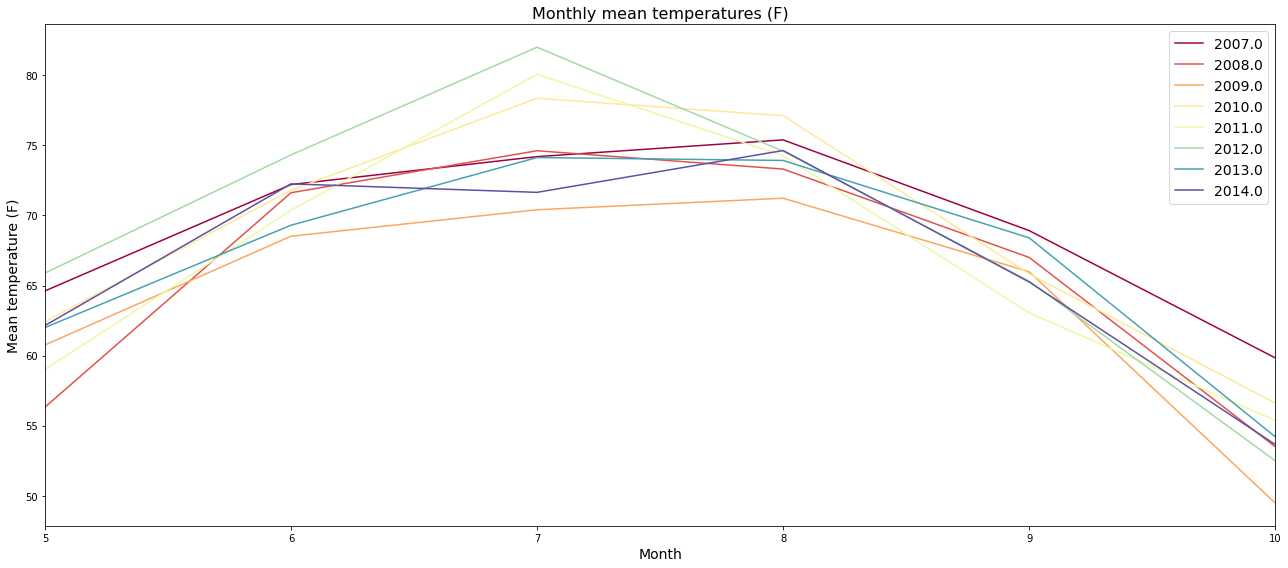

In [47]:
# plot temperature by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'tavg', data = weather, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(fontsize = 14)
plt.title('Monthly mean temperatures (F)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean temperature (F)',fontsize=14)
plt.xlim(weather['month'].min(), weather['month'].max())
plt.tight_layout()

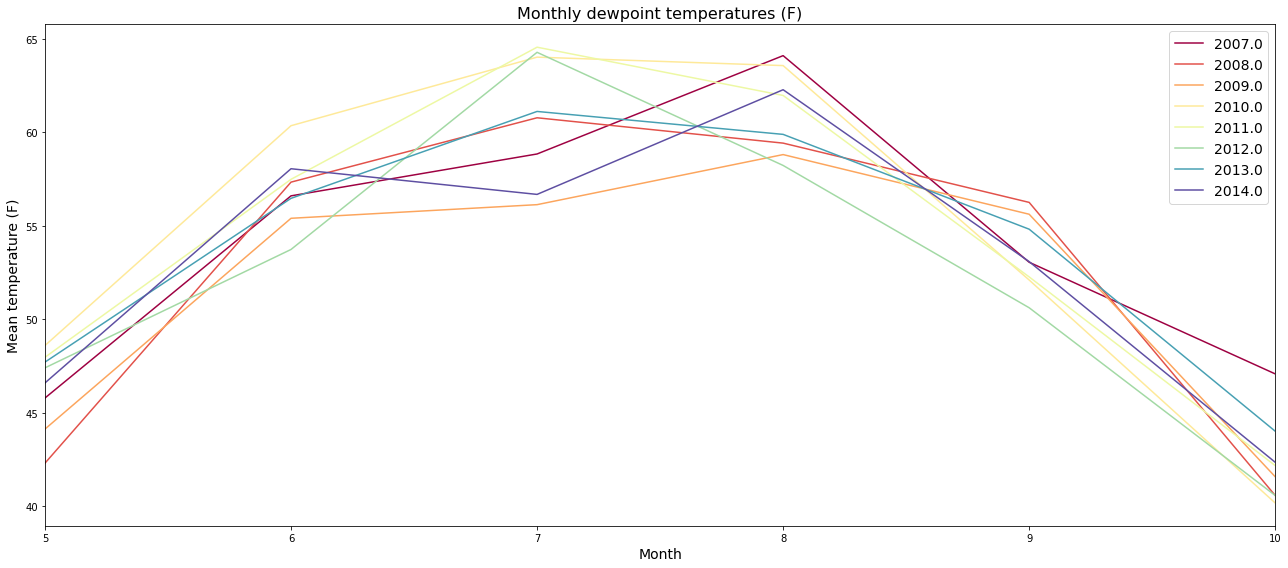

In [48]:
# plot temperature by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'dewpoint', data = weather, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(fontsize = 14)
plt.title('Monthly dewpoint temperatures (F)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean temperature (F)',fontsize=14)
plt.xlim(weather['month'].min(), weather['month'].max())
plt.tight_layout()

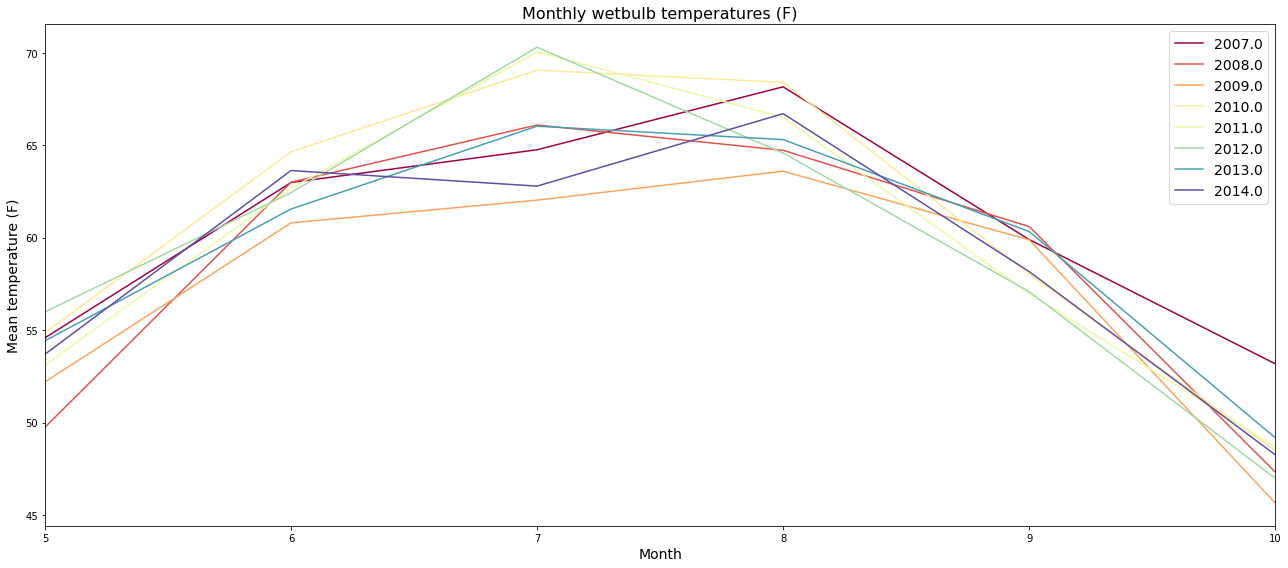

In [49]:
# plot temperature by month and year
plt.figure(figsize=(18,8))
sns.lineplot(x = 'month',y = 'wetbulb', data = weather, hue = 'year', ci = None, 
             legend = 'full', palette = 'Spectral')
plt.legend(fontsize = 14)
plt.title('Monthly wetbulb temperatures (F)', fontsize=16)
plt.xlabel('Month',fontsize=14)
plt.ylabel('Mean temperature (F)',fontsize=14)
plt.xlim(weather['month'].min(), weather['month'].max())
plt.tight_layout()

We see that the temperature is generally high across all years in the months of July and August. Therefore we can deduce that with higher temperature, there are higher cases of west nile virus present. As such, we will feature engineer a new feature, relative humidity using average temperature and dewpoint temperature.

### Creating column for relative humidity with temperature and dewpoint data

In [50]:
# Creating new column for relative humidity with temperature and dewpoint data
# https://bmcnoldy.rsmas.miami.edu/Humidity.html

# Function to convert fahrenheit to celsius
def to_celsius(x):
    c = ((x - 32) * 5.0)/9.0
    return float(c)

# Applying function to 'tavg', 'dewpoint'
weather['tavg_c'] = weather['tavg'].apply(to_celsius)
weather['dewpoint_c'] = weather['dewpoint'].apply(to_celsius)

# Function to calculate relative humidity
def rel_humidity(row):
    row['rel_humidity'] = round(100*(math.exp((17.625*row['dewpoint_c'])/(243.04+row['dewpoint_c'])) \
                          / math.exp((17.625*row['tavg_c'])/(243.04+row['tavg_c']))))
    return row

# Applying rel_humidity to weather dataframe
weather = weather.apply(rel_humidity, axis = 1)

In [51]:
weather

,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,sunset,...,resultdir,avgspeed,year,month,week,dayofweek,yearweek,tavg_c,dewpoint_c,rel_humidity
0,2007-05-01,83.5,51.0,67.5,51.0,56.5,0.0,2.5,448.0,1849.0,...,26.0,9.40,2007.0,5.0,18.0,1.0,200718.0,19.722222,10.555556,55
1,2007-05-02,59.5,42.5,51.5,42.0,47.0,13.5,0.0,447.0,1850.0,...,3.0,13.40,2007.0,5.0,18.0,2.0,200718.0,10.833333,5.555556,70
2,2007-05-03,66.5,47.0,57.0,40.0,49.0,8.0,0.0,446.0,1851.0,...,6.5,12.55,2007.0,5.0,18.0,3.0,200718.0,13.888889,4.444444,53
3,2007-05-04,72.0,50.0,61.0,41.5,50.0,4.0,0.0,444.0,1852.0,...,7.5,10.60,2007.0,5.0,18.0,4.0,200718.0,16.111111,5.277778,49
4,2007-05-05,66.0,53.5,60.0,38.5,49.5,5.0,0.0,443.0,1853.0,...,7.0,11.75,2007.0,5.0,18.0,5.0,200718.0,15.555556,3.611111,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2014-10-27,78.0,52.5,65.5,51.5,58.5,0.5,1.0,618.0,1653.0,...,19.0,13.25,2014.0,10.0,44.0,0.0,201444.0,18.611111,10.833333,61
1468,2014-10-28,67.0,46.5,57.0,39.0,47.5,8.0,0.0,619.0,1651.0,...,26.0,15.10,2014.0,10.0,44.0,1.0,201444.0,13.888889,3.888889,51
1469,2014-10-29,49.0,38.0,44.0,33.0,41.0,21.0,0.0,620.0,1650.0,...,29.0,9.45,2014.0,10.0,44.0,2.0,201444.0,6.666667,0.555556,65
1470,2014-10-30,52.0,34.5,43.5,34.5,41.0,21.5,0.0,622.0,1649.0,...,23.5,6.00,2014.0,10.0,44.0,3.0,201444.0,6.388889,1.388889,70


In [52]:
# Creating columns for weekly average temperature and weekly preciptotal

def weekly_precip_temp(row):
    yearweek = row['yearweek']
    row['weekly_preciptotal'] = weather.groupby('yearweek').sum().loc[yearweek]['preciptotal']

    temp_sum = weather.groupby('yearweek').sum().loc[yearweek]['tavg']
    n_days = weather[weather['yearweek'] == yearweek].shape[0]
    row['weekly_avgtemp'] = temp_sum / n_days
    return row

In [53]:
weather = weather.apply(weekly_precip_temp, axis = 1)

## Spray Data

In [59]:
explore(spray)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14835 non-null  datetime64[ns]
 1   Time       14251 non-null  object        
 2   Latitude   14835 non-null  float64       
 3   Longitude  14835 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 463.7+ KB
None
date column has no null values.
time column has 584 null values.
latitude column has no null values.
longitude column has no null values.
543 number of duplicated rows.


,date,time,latitude,longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858
...,...,...,...,...
14830,2013-09-05,8:34:11 PM,42.006587,-87.812355
14831,2013-09-05,8:35:01 PM,42.006192,-87.816015
14832,2013-09-05,8:35:21 PM,42.006022,-87.817392
14833,2013-09-05,8:35:31 PM,42.005453,-87.817423


There seems to be some duplicates and null values within the datasets. We will work on the duplicates first.

In [60]:
spray['time'].value_counts().head()

7:44:32 PM    541
9:40:27 PM      5
8:55:46 PM      5
8:57:46 PM      5
8:57:56 PM      5
Name: time, dtype: int64

In [61]:
spray.loc[spray['time'] == "7:44:32 PM"]

,date,time,latitude,longitude
489,2011-09-07,7:44:32 PM,41.98646,-87.794225
490,2011-09-07,7:44:32 PM,41.98646,-87.794225
491,2011-09-07,7:44:32 PM,41.98646,-87.794225
492,2011-09-07,7:44:32 PM,41.98646,-87.794225
493,2011-09-07,7:44:32 PM,41.98646,-87.794225
...,...,...,...,...
1025,2011-09-07,7:44:32 PM,41.98646,-87.794225
1026,2011-09-07,7:44:32 PM,41.98646,-87.794225
1027,2011-09-07,7:44:32 PM,41.98646,-87.794225
1028,2011-09-07,7:44:32 PM,41.98646,-87.794225


In [62]:
spray.loc[spray['time'] == "8:57:46 PM"]

,date,time,latitude,longitude
1981,2011-09-07,8:57:46 PM,41.975932,-87.815778
4439,2013-07-25,8:57:46 PM,41.948870,-87.736673
5677,2013-07-25,8:57:46 PM,41.961133,-87.729082
8348,2013-08-15,8:57:46 PM,41.904732,-87.767027
13758,2013-08-29,8:57:46 PM,41.986322,-87.681377


These duplicates are deemed to be true duplicates on the basis that they have the same dates. As such, we will be dropping these rows.


In [63]:
# dropping the duplicates

spray.drop_duplicates(inplace = True)
spray.isnull().sum()

date           0
time         584
latitude       0
longitude      0
dtype: int64

There are 584 null values in the 'time' column. Since there is no appropriate replacement for the null values in this column, we will be dropping this column.

In [64]:
# dropping 'Time' column
spray.drop(columns = 'time', inplace = True)
spray.isnull().sum()

date         0
latitude     0
longitude    0
dtype: int64

In [65]:
print(spray["date"].nunique())
spray["date"].value_counts()

10


2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2013-07-25    1607
2013-08-22    1587
2011-09-07    1573
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: date, dtype: int64

It is noted that there are only 10 unique spray dates and the number of sprays for each unique date is stated above. 

In [66]:
mapdata = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")

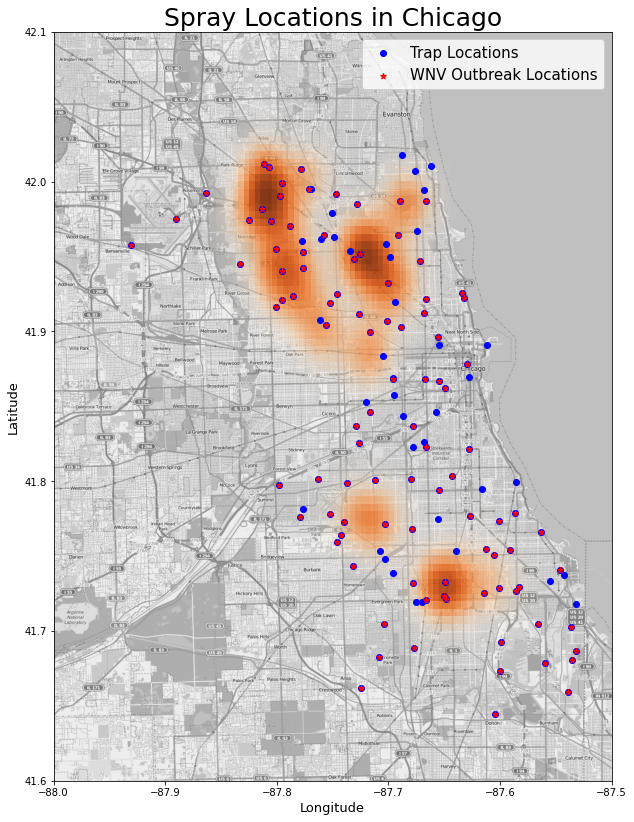

In [67]:
alpha_cm = plt.cm.Oranges
alpha_cm._init()
alpha_cm._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm.N) / 10 - 1)[::-1]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-88, -87.5, 41.6, 42.1)

# Spray location
X = spray[['longitude', 'latitude']].drop_duplicates().values
kd = KernelDensity(bandwidth=0.015)
kd.fit(X)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv = np.exp(kd.score_samples(gridpoints).reshape(100,100))

#kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv, origin='lower', cmap=alpha_cm, extent=lon_lat_box, aspect=aspect)

# trap locations
trap_locations = train[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(trap_locations[:,0], trap_locations[:,1], marker='o', c='b', label='Trap Locations')

# wnn outbreak locations
wnv_locations = train[train['wnvpresent'] != 0][['longitude', 'latitude']].drop_duplicates().values
plt.scatter(wnv_locations[:,0], wnv_locations[:,1], marker='*', c='r', label='WNV Outbreak Locations')

plt.title('Spray Locations in Chicago', fontsize=25)
plt.legend(fontsize=15)
plt.xlabel('Longitude', fontsize=13)
plt.ylabel('Latitude', fontsize=13)
plt.savefig('../images/Spray Locations.png')

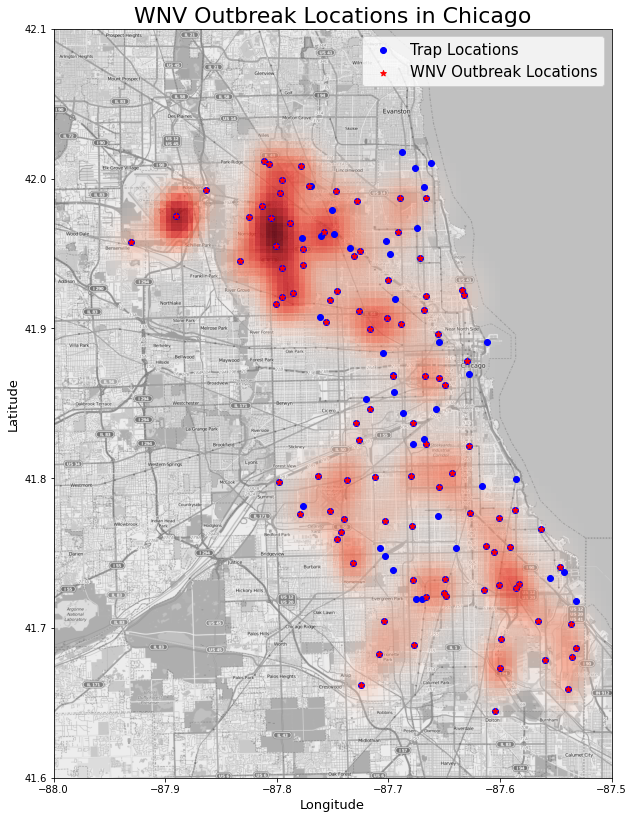

In [68]:
alpha_cm1 = plt.cm.Reds
alpha_cm1._init()
alpha_cm1._lut[:-3,-1] = abs(np.logspace(0, 1, alpha_cm1.N) / 10 - 1)[::-1]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]

lon_lat_box = (-88, -87.5, 41.6, 42.1)

#Traps where only WNV is present
wnv = train[train['wnvpresent'] == 1]
wnv = wnv.groupby(['date','longitude', 'latitude']).max()['wnvpresent'].reset_index()
X1 = wnv[['longitude', 'latitude']].values
kd1 = KernelDensity(bandwidth=0.015)
kd1.fit(X1)

xv,yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
gridpoints = np.array([xv.ravel(),yv.ravel()]).T
zv1 = np.exp(kd1.score_samples(gridpoints).reshape(100,100))

#kernel density
plt.figure(figsize=(10,14))
plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)
plt.imshow(zv1, origin='lower', cmap=alpha_cm1, extent=lon_lat_box, aspect=aspect)

# trap locations
trap_locations = train[['longitude', 'latitude']].drop_duplicates().values
plt.scatter(trap_locations[:,0], trap_locations[:,1], marker='o', c='b', label='Trap Locations')

# wnn outbreak locations
wnv_locations = train[train['wnvpresent'] != 0][['longitude', 'latitude']].drop_duplicates().values
plt.scatter(wnv_locations[:,0], wnv_locations[:,1], marker='*', c='r', label='WNV Outbreak Locations')

plt.title('WNV Outbreak Locations in Chicago', fontsize = 22)
plt.legend(fontsize=15)
plt.xlabel('Longitude', fontsize=13)
plt.ylabel('Latitude', fontsize=13)
plt.savefig('../images/WNV Outbreak Locations.png')

## Merging train and weather datasets

In [69]:
combined1 = weather.merge(train, on = ['date','year','month','week','yearweek','dayofweek'])
combined1

,date,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,sunset,...,yearweek,tavg_c,dewpoint_c,rel_humidity,weekly_preciptotal,weekly_avgtemp,species,latitude,longitude,wnvpresent
0,2007-05-29,88.0,62.5,75.5,58.5,65.5,0.0,10.5,421.0,1917.0,...,200722.0,24.166667,14.722222,56,0.655,73.142857,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,0
1,2007-05-29,88.0,62.5,75.5,58.5,65.5,0.0,10.5,421.0,1917.0,...,200722.0,24.166667,14.722222,56,0.655,73.142857,CULEX RESTUANS,41.954690,-87.800991,0
2,2007-05-29,88.0,62.5,75.5,58.5,65.5,0.0,10.5,421.0,1917.0,...,200722.0,24.166667,14.722222,56,0.655,73.142857,CULEX RESTUANS,41.994991,-87.769279,0
3,2007-05-29,88.0,62.5,75.5,58.5,65.5,0.0,10.5,421.0,1917.0,...,200722.0,24.166667,14.722222,56,0.655,73.142857,CULEX PIPIENS/RESTUANS,41.974089,-87.824812,0
4,2007-05-29,88.0,62.5,75.5,58.5,65.5,0.0,10.5,421.0,1917.0,...,200722.0,24.166667,14.722222,56,0.655,73.142857,CULEX RESTUANS,41.974089,-87.824812,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,2013-09-26,75.0,52.5,64.0,52.0,58.0,1.0,0.0,543.0,1742.0,...,201339.0,17.777778,11.111111,65,0.310,64.785714,CULEX PIPIENS/RESTUANS,41.763733,-87.742302,1
10502,2013-09-26,75.0,52.5,64.0,52.0,58.0,1.0,0.0,543.0,1742.0,...,201339.0,17.777778,11.111111,65,0.310,64.785714,CULEX PIPIENS/RESTUANS,41.987280,-87.666066,0
10503,2013-09-26,75.0,52.5,64.0,52.0,58.0,1.0,0.0,543.0,1742.0,...,201339.0,17.777778,11.111111,65,0.310,64.785714,CULEX PIPIENS/RESTUANS,41.912563,-87.668055,0
10504,2013-09-26,75.0,52.5,64.0,52.0,58.0,1.0,0.0,543.0,1742.0,...,201339.0,17.777778,11.111111,65,0.310,64.785714,CULEX PIPIENS/RESTUANS,42.009876,-87.807277,0


In [70]:
combined1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                10506 non-null  datetime64[ns]
 1   tmax                10506 non-null  float64       
 2   tmin                10506 non-null  float64       
 3   tavg                10506 non-null  float64       
 4   dewpoint            10506 non-null  float64       
 5   wetbulb             10506 non-null  float64       
 6   heat                10506 non-null  float64       
 7   cool                10506 non-null  float64       
 8   sunrise             10506 non-null  float64       
 9   sunset              10506 non-null  float64       
 10  codesum             10506 non-null  float64       
 11  preciptotal         10506 non-null  float64       
 12  stnpressure         10506 non-null  float64       
 13  resultspeed         10506 non-null  float64   

## EDA on combined dataset

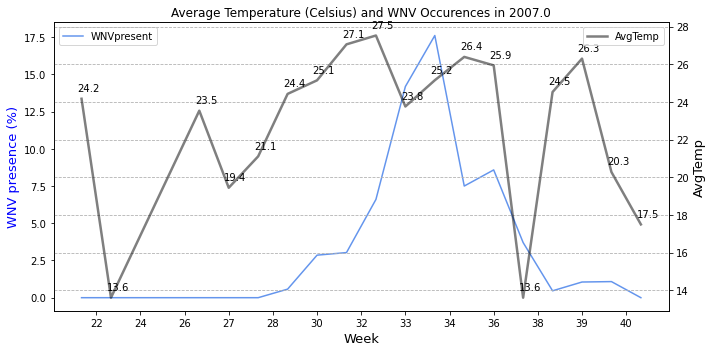

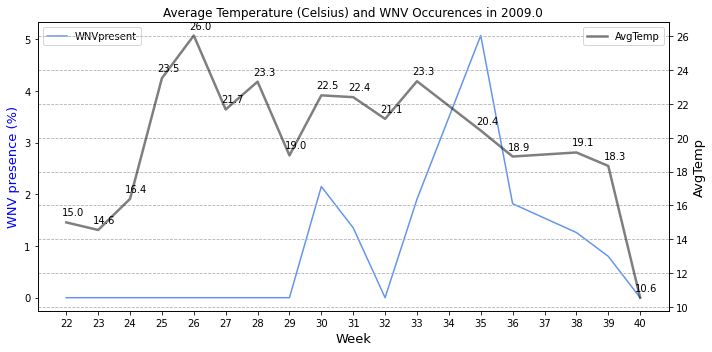

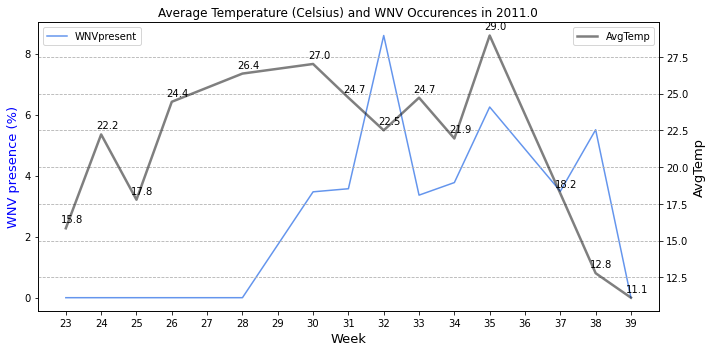

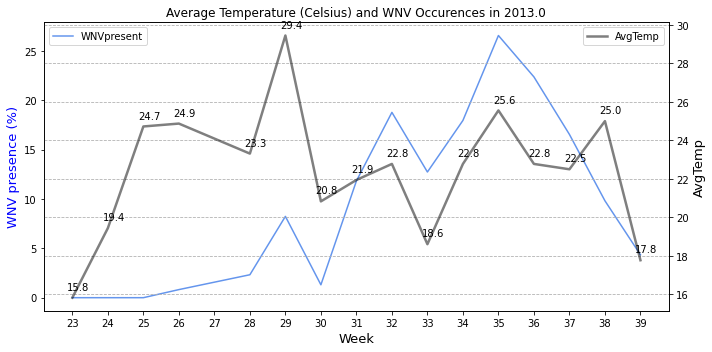

In [71]:
for yr in combined1['year'].unique():
    fig, ax1 = plt.subplots(figsize=(10,5))
    label_format = '{:,.0f}'

    # bar plot for WNV presence
    kwargs = {'alpha': 0.5}
    sns.lineplot(x = combined1[combined1['year'] == yr]['week'],
                 y = combined1[combined1['year'] == yr]['wnvpresent']*100,
                data = combined1, ci=None, color='cornflowerblue', label='WNVpresent', ax=ax1, markers = True)
    ax1.set_xlabel('Week', fontsize=13)
    ax1.set_ylabel('WNV presence (%)', fontsize=13, color='blue')
    ax1.set_xticklabels(ax1.get_xticklabels());
    ax1.legend(loc=2)

    # fixing xticks with FixedLocator but also using MaxNLocator to avoid cramped x-labels
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(20))
    ticks_loc = ax1.get_xticks().tolist()
    ax1.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax1.set_xticklabels([label_format.format(x) for x in ticks_loc])

#     # label points on the plot
#     for x, y in zip(combined1[combined1['year'] == yr]['week'],
#                     combined1[combined1['year'] == yr]['wnvpresent']*100):
#      # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
#         plt.text(x = x, # x-coordinate position of data label
#                  y = y, # y-coordinate position of data label, adjusted to be 150 below the data point
#                  s = '{:.0f}'.format(y), # data label, formatted to ignore decimals
#                  color = 'blue') # set colour of line

    # setting up dataframe for plotting
    avg_temp = (combined1[combined1['year'] == yr].groupby(['week'])['tavg_c'].mean())
    df_avg_temp = pd.DataFrame(avg_temp)

    # line plot for temp
    ax2 = ax1.twinx()
    sns.lineplot(x = df_avg_temp.index, y = df_avg_temp['tavg_c'], data = df_avg_temp,
                ci=None, color='black', linewidth=2.5, label='AvgTemp', ax=ax2, **kwargs, markers = True)#, fill=False)
    ax2.set_ylabel('AvgTemp', fontsize=13, color='black')
    ax2.legend(loc=1)
    
    # label points on the plot
    for x, y in zip(df_avg_temp.index, df_avg_temp['tavg_c']):
     # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
        plt.text(x = x-0.15, # x-coordinate position of data label
                 y = y+0.4, # y-coordinate position of data label, adjusted to be 150 below the data point
                 s = '{:.1f}'.format(y), # data label, formatted to ignore decimals
                 color = 'black') # set colour of line
    plt.title(f'Average Temperature (Celsius) and WNV Occurences in {yr}')
    plt.grid(linestyle='--')
    fig.tight_layout()

When plotting the weekly average temperature (celsius) and West Nile Virus occurences against the weeks of the individual years, we can see that the weekly average temperature can potentially be used as a lead indicator of the virus occurence.  A lead indicator shows a change in direction before a corresponding change in the target variable.

Looking at the graphs above, we can see that a peak in the weekly average temperature comes just 2-3 weeks before a peak in the percentage of the presence of the virus. For example in the 2009 graph, at week 28, the temperature seems to spike to 23.3 degree celsius. 2 weeks later at week 30, we can see there there is a spike noted for the WNV presence. Similarly at week 33 of the same graph, the temperature spikes again to 23.3 degree celsius and then 2 weeks later at week 35 we can see that there is a spike in the WNV presence.

Likewise in the 2011 graph, we can see a similar trend occuring where the temperature reaches a peak of 27.0 degree celsius at week 30 and then 2 weeks later at week 32 the WNV presence spikes. This pattern occurs again at week 33 to 35 and week 35 to 38. This pattern is also seen in the 2013 graph at week 26 to 29, week 29 to 32 and lastly at week 32 to 35.

This solidifies the weekly average temperature’s position as a lead indicator for the presence of the West Nile Virus. With this in mind, when feature engineering, we will then proceed to feature engineer time lag columns for the weekly average temperature by shifting the weekly average temperatures between 1-4 weeks back. This is done in an attempt to better determine its correlation to the target variable (WNV presence).

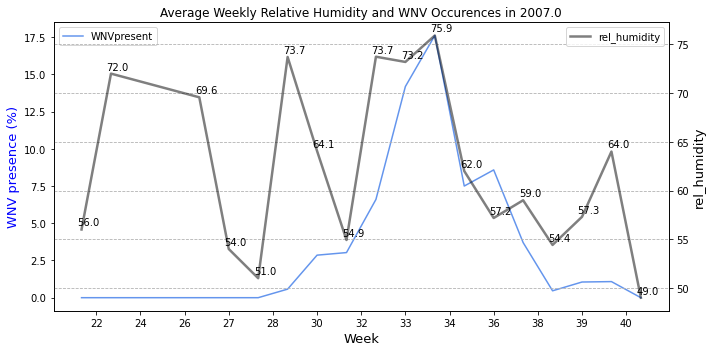

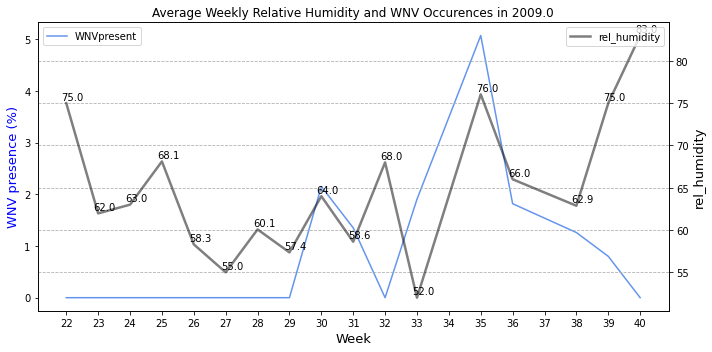

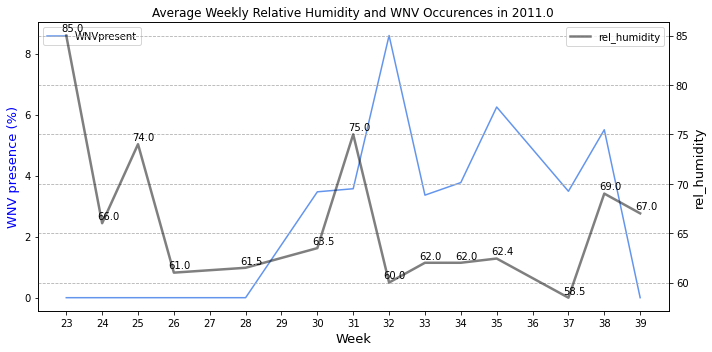

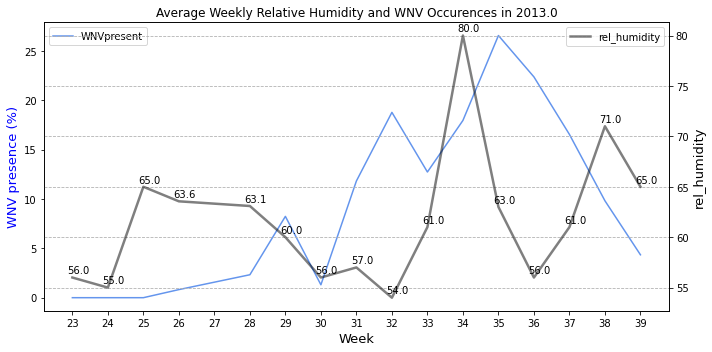

In [72]:
for yr in combined1['year'].unique():
    fig, ax1 = plt.subplots(figsize=(10,5))
    label_format = '{:,.0f}'

    # bar plot for WNV presence
    kwargs = {'alpha': 0.5}
    sns.lineplot(x = combined1[combined1['year'] == yr]['week'], y = combined1[combined1['year'] == yr]['wnvpresent']*100,
                data = combined1, ci=None, color='cornflowerblue', label='WNVpresent', ax=ax1)
    ax1.set_xlabel('Week', fontsize=13)
    ax1.set_ylabel('WNV presence (%)', fontsize=13, color='blue')
    ax1.set_xticklabels(ax1.get_xticklabels());
    ax1.legend(loc=2)

    # fixing xticks with FixedLocator but also using MaxNLocator to avoid cramped x-labels
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(20))
    ticks_loc = ax1.get_xticks().tolist()
    ax1.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax1.set_xticklabels([label_format.format(x) for x in ticks_loc])

    # setting up dataframe for plotting
    rel_humidity = (combined1[combined1['year'] == yr].groupby(['week'])['rel_humidity'].mean())
    df_rel_humidity = pd.DataFrame(rel_humidity)

    # line plot for temp
    ax2 = ax1.twinx()
    sns.lineplot(x = df_rel_humidity.index, y = df_rel_humidity['rel_humidity'], data = df_rel_humidity,
                ci=None, color='black', linewidth=2.5, label='rel_humidity', ax=ax2, **kwargs)#, fill=False)
    ax2.set_ylabel('rel_humidity', fontsize=13, color='black')
    ax2.legend(loc=1)
    
    # label points on the plot
    for x, y in zip(df_rel_humidity.index, df_rel_humidity['rel_humidity']):
     # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
        plt.text(x = x-0.15, # x-coordinate position of data label
                 y = y+0.4, # y-coordinate position of data label, adjusted to be 150 below the data point
                 s = '{:.1f}'.format(y), # data label, formatted to ignore decimals
                 color = 'black') # set colour of line
    plt.title(f'Average Weekly Relative Humidity and WNV Occurences in {yr}')
    plt.grid(linestyle='--')
    fig.tight_layout()

When comparing this to the weekly average relative humidity graphs, we can see that there is a semblance of a similar trend ongoing as well. This is of no surprise as relative humidity is important to mosquito activity. In general, high humidity conditions favor mosquito activity, while low humidity suppresses activity and may even cause mortality. As such, we will also be feature engineering the weekly average relative humidity for a time lag of between 1-4 weeks.

### Precipitation and WNV Occurences

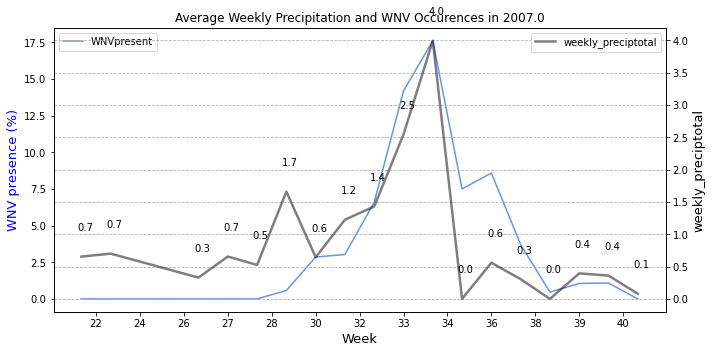

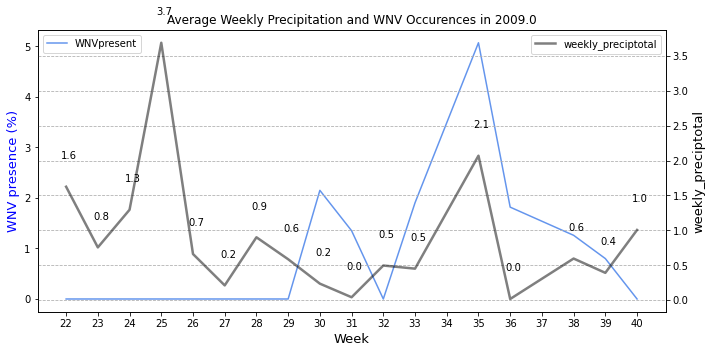

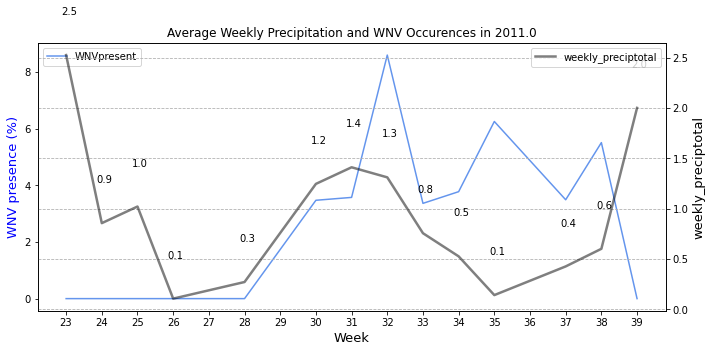

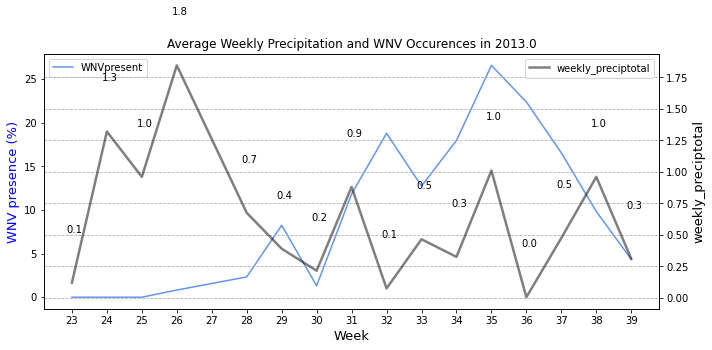

In [73]:
for yr in combined1['year'].unique():
    fig, ax1 = plt.subplots(figsize=(10,5))
    label_format = '{:,.0f}'
    
    # bar plot for WNV presence
    kwargs = {'alpha': 0.5}
    sns.lineplot(x = combined1[combined1['year'] == yr]['week'], y = combined1[combined1['year'] == yr]['wnvpresent']*100,
                data = combined1, ci=None, color='cornflowerblue', label='WNVpresent', ax=ax1)
    ax1.set_xlabel('Week', fontsize=13)
    ax1.set_ylabel('WNV presence (%)', fontsize=13, color='blue')
    ax1.set_xticklabels(ax1.get_xticklabels());
    ax1.legend(loc=2)
    
    # fixing xticks with FixedLocator but also using MaxNLocator to avoid cramped x-labels
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(20))
    ticks_loc = ax1.get_xticks().tolist()
    ax1.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax1.set_xticklabels([label_format.format(x) for x in ticks_loc])
    
    # setting up dataframe for plotting
    weekly_preciptotal = (combined1[combined1['year'] == yr].groupby(['week'])['weekly_preciptotal'].mean())
    df_weekly_preciptotal = pd.DataFrame(weekly_preciptotal)
    
    # line plot for temp
    ax2 = ax1.twinx()
    sns.lineplot(x = df_weekly_preciptotal.index, y = df_weekly_preciptotal['weekly_preciptotal'], data = df_weekly_preciptotal,
                ci=None, color='black', linewidth=2.5, label='weekly_preciptotal', ax=ax2, **kwargs)#, fill=False)
    ax2.set_ylabel('weekly_preciptotal', fontsize=13, color='black')
    ax2.legend(loc=1)
    
    # label points on the plot
    for x, y in zip(df_weekly_preciptotal.index, df_weekly_preciptotal['weekly_preciptotal']):
     # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
        plt.text(x = x-0.15, # x-coordinate position of data label
                 y = y+0.4, # y-coordinate position of data label, adjusted to be 150 below the data point
                 s = '{:.1f}'.format(y), # data label, formatted to ignore decimals
                 color = 'black') # set colour of line
    plt.title(f'Average Weekly Precipitation and WNV Occurences in {yr}')
    plt.grid(linestyle='--')
    fig.tight_layout()

When looking at the relationship between precipitation and WNV cases, we can see from the graph in Year 2007 that certain peak in WNV cases only occur when there is high precipitation. However, this trend is not as evident across the four years as compared to the graphs looking at the relationship between temperature and humidity. For example in the Year 2013 graph, at the week 32 peak of the WNV presence line, it seems to be from a time lag of 1 week ago where there was a peak in the weekly precipitation line at week 31. However, at the next peak in WNV presence at week 35, it is unclear if this was due to the spike in weekly precipitation in the same week (week 35) or if it was due to a smaller spike at week 33.
Nonetheless, keeping this in mind, we will proceed with feature engineering this column as well as it seems like it could be a potential lead indicator in predicting the spikes in the WNV presence.

In [74]:
# Creating time lag columns for precipiation, avg_temp and relative humidity

def precip_temp_relhumid_lag(row):   
    # Getting average temperature one week before
    yearweek = row['yearweek']
    
    # Calculating average temperature for up to four weeks before
    for i in range(4):
        try:
            row[f'templag{i+1}'] = combined1[combined1['yearweek'] == (yearweek - (i+1))]['weekly_avgtemp'].unique()[0]
            
        # For the first 4 weeks of the year where no previous data exists, create rough estimate of temperatures
        except IndexError:
            row[f'templag{i+1}'] = row['weekly_avgtemp'] - i

        try:
            row[f'rainlag{i+1}'] = combined1[combined1['yearweek'] == (yearweek - (i+1))]['weekly_preciptotal'].unique()[0]
            
        # Use average of column if no data available
        except IndexError:
            row[f'rainlag{i+1}'] = combined1['weekly_preciptotal'].mean()

        try:
            row[f'humidlag{i+1}'] = combined1[combined1['yearweek'] == (yearweek - (i+1))]['rel_humidity'].unique()[0]
            
        # Use average of column if no data available
        except IndexError:
            row[f'humidlag{i+1}'] = combined1['rel_humidity'].mean()

    return row

In [75]:
combined1 = combined1.apply(precip_temp_relhumid_lag, axis = 1)

In [76]:
combined1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                10506 non-null  datetime64[ns]
 1   tmax                10506 non-null  float64       
 2   tmin                10506 non-null  float64       
 3   tavg                10506 non-null  float64       
 4   dewpoint            10506 non-null  float64       
 5   wetbulb             10506 non-null  float64       
 6   heat                10506 non-null  float64       
 7   cool                10506 non-null  float64       
 8   sunrise             10506 non-null  float64       
 9   sunset              10506 non-null  float64       
 10  codesum             10506 non-null  float64       
 11  preciptotal         10506 non-null  float64       
 12  stnpressure         10506 non-null  float64       
 13  resultspeed         10506 non-null  float64   

## Encoding of species
​
As identified above during EDA, only 2 out of 6 mosquito species are carriers of WNV. The most dangerous specie is the Culex Pipiens, followed by the Culex Restuans.
​

The following are the percentages of WNV samples in total samples based on species:
- WNV in Culex Pipiens was 0.0889 (240 positive pools vs 2699 total pools)
- WNV in Pipiens and Restuans mix was 0.055 (262 positive pools vs 4752 total pools)
- WNV in Culex Restuans was 0.018 (49 positive pools vs 2740 total pools)
​

Given this relationship, we will be converting our species to ordinal numeric data, where a ranking order will be given to the species based on their percentage of WNV samples.

In [77]:
# changing 'species' feature to ordinal numeric

WNV_ordinal_dict = {'CULEX PIPIENS': 3,
                    'CULEX PIPIENS/RESTUANS': 2,
                    'CULEX RESTUANS': 1,
                    'CULEX TERRITANS': 0,
                    'CULEX SALINARIUS': 0,
                    'CULEX TARSALIS': 0,
                    'CULEX ERRATICUS': 0}
    
combined1['species'] = combined1['species'].map(WNV_ordinal_dict)

## Polynomial Features

As our features generally have a low correlation to our target variable ('wnvpresent'), we will be using polynomial features to include features that have better correlation to the target variable and include them in our combined dataset. 

In [78]:
combined1.corr()['wnvpresent'].sort_values(ascending = False)

wnvpresent            1.000000
species               0.121335
templag3              0.120029
templag2              0.113180
sunrise               0.105227
week                  0.104171
month                 0.100143
weekly_preciptotal    0.098696
humidlag1             0.090672
templag4              0.087834
dewpoint_c            0.085883
dewpoint              0.085883
wetbulb               0.079933
tmin                  0.074048
templag1              0.069032
tavg_c                0.064256
tavg                  0.064256
cool                  0.058101
weekly_avgtemp        0.054949
yearweek              0.053012
rel_humidity          0.052098
codesum               0.051882
year                  0.050865
tmax                  0.048244
rainlag1              0.043917
latitude              0.028697
rainlag2              0.024049
humidlag2             0.016724
dayofweek             0.014968
stnpressure           0.010651
humidlag4             0.005308
resultdir             0.000175
precipto

In [79]:
# Dropping object columns as polynomial features does not work with string values
X = combined1.select_dtypes(exclude = 'object')._get_numeric_data().drop(columns = ['wnvpresent'])
y = train['wnvpresent']

In [80]:
X

,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,...,humidlag1,templag2,rainlag2,humidlag2,templag3,rainlag3,humidlag3,templag4,rainlag4,humidlag4
0,88.0,62.5,75.5,58.5,65.5,0.0,10.5,421.0,1917.0,1.0,...,63.514658,72.142857,0.989038,63.514658,71.142857,0.989038,63.514658,70.142857,0.989038,63.514658
1,88.0,62.5,75.5,58.5,65.5,0.0,10.5,421.0,1917.0,1.0,...,63.514658,72.142857,0.989038,63.514658,71.142857,0.989038,63.514658,70.142857,0.989038,63.514658
2,88.0,62.5,75.5,58.5,65.5,0.0,10.5,421.0,1917.0,1.0,...,63.514658,72.142857,0.989038,63.514658,71.142857,0.989038,63.514658,70.142857,0.989038,63.514658
3,88.0,62.5,75.5,58.5,65.5,0.0,10.5,421.0,1917.0,1.0,...,63.514658,72.142857,0.989038,63.514658,71.142857,0.989038,63.514658,70.142857,0.989038,63.514658
4,88.0,62.5,75.5,58.5,65.5,0.0,10.5,421.0,1917.0,1.0,...,63.514658,72.142857,0.989038,63.514658,71.142857,0.989038,63.514658,70.142857,0.989038,63.514658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,75.0,52.5,64.0,52.0,58.0,1.0,0.0,543.0,1742.0,0.5,...,71.000000,72.142857,0.475000,61.000000,71.785714,0.005000,56.000000,79.357143,1.010000,63.000000
10502,75.0,52.5,64.0,52.0,58.0,1.0,0.0,543.0,1742.0,0.5,...,71.000000,72.142857,0.475000,61.000000,71.785714,0.005000,56.000000,79.357143,1.010000,63.000000
10503,75.0,52.5,64.0,52.0,58.0,1.0,0.0,543.0,1742.0,0.5,...,71.000000,72.142857,0.475000,61.000000,71.785714,0.005000,56.000000,79.357143,1.010000,63.000000
10504,75.0,52.5,64.0,52.0,58.0,1.0,0.0,543.0,1742.0,0.5,...,71.000000,72.142857,0.475000,61.000000,71.785714,0.005000,56.000000,79.357143,1.010000,63.000000


In [81]:
# Initialise PolynomialFeatures
poly = PolynomialFeatures(degree = 2, include_bias = False)

 # Fit model
Xpoly = poly.fit_transform(X)

# Look at shape of transformed data
Xpoly.shape


(10506, 860)

In [82]:
# Adds appropriate feature names to all polynomial features
Xpoly = pd.DataFrame(Xpoly,columns=poly.get_feature_names_out(X.columns))

# Generates list of poly feature correlations
Xpoly_corrs = Xpoly.corrwith(y)

# Shows features most highly correlated (positively) with target
Xpoly_corrs.sort_values(ascending=False).head(15)

sunrise templag2              0.155336
sunrise templag1              0.151299
sunrise templag3              0.150898
sunrise weekly_avgtemp        0.150030
species humidlag1             0.149567
month humidlag1               0.147775
week humidlag1                0.147389
dewpoint_c species            0.147360
humidlag1 templag3            0.146075
week templag2                 0.144737
wetbulb sunrise               0.143208
dewpoint sunrise              0.142001
week templag3                 0.141636
species templag2              0.141609
weekly_preciptotal species    0.141584
dtype: float64

In [83]:
# Adding top 5 polynomial features into combined1

combined1['sunrise_weekly_avgtemp'] = combined1['sunrise'] * combined1['weekly_avgtemp']
combined1['sunrise_weekly_templag2'] = combined1['sunrise'] * combined1['templag2']
combined1['dewpoint_c_species'] = combined1['dewpoint'] * combined1['species']
combined1['sunrise_weekly_templag3'] = combined1['sunrise'] * combined1['templag3']
combined1['sunrise_weekly_templag1'] = combined1['sunrise'] * combined1['templag1']

combined1.shape

(10506, 47)

## Merging test and weather datasets

In [84]:
test

,id,date,species,latitude,longitude,year,month,week,dayofweek
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,41.954690,-87.800991,2008,6,24,2
1,2,2008-06-11,CULEX RESTUANS,41.954690,-87.800991,2008,6,24,2
2,3,2008-06-11,CULEX PIPIENS,41.954690,-87.800991,2008,6,24,2
3,4,2008-06-11,CULEX SALINARIUS,41.954690,-87.800991,2008,6,24,2
4,5,2008-06-11,CULEX TERRITANS,41.954690,-87.800991,2008,6,24,2
...,...,...,...,...,...,...,...,...,...
116288,116289,2014-10-02,CULEX SALINARIUS,41.925652,-87.633590,2014,10,40,3
116289,116290,2014-10-02,CULEX TERRITANS,41.925652,-87.633590,2014,10,40,3
116290,116291,2014-10-02,CULEX TARSALIS,41.925652,-87.633590,2014,10,40,3
116291,116292,2014-10-02,UNSPECIFIED CULEX,41.925652,-87.633590,2014,10,40,3


In [85]:
# changing 'species' feature to ordinal numeric

WNV_ordinal_dict = {'CULEX PIPIENS': 3,
                    'CULEX PIPIENS/RESTUANS': 2,
                    'CULEX RESTUANS': 1,
                    'CULEX TERRITANS': 0,
                    'CULEX SALINARIUS': 0,
                    'CULEX TARSALIS': 0,
                    'CULEX ERRATICUS': 0,
                    'UNSPECIFIED CULEX':0}
    
test['species'] = test['species'].map(WNV_ordinal_dict)

In [86]:
combined_test = test.merge(weather, on = ['date','year','month','week','dayofweek'])

In [94]:
# Creating time lag columns for precipiation, avg_temp and relative humidity

def test_precip_temp_relhumid_lag(row):   
    # Getting average temperature one week before
    yearweek = row['yearweek']
    
    # Calculating average temperature for up to four weeks before
    for i in range(4):
        try:
            row[f'templag{i+1}'] = combined_test[combined_test['yearweek'] == (yearweek - (i+1))]['weekly_avgtemp'].unique()[0]
            
        # For the first 4 weeks of the year where no previous data exists, create rough estimate of temperatures
        except IndexError:
            row[f'templag{i+1}'] = row['weekly_avgtemp'] - i

        try:
            row[f'rainlag{i+1}'] = combined_test[combined_test['yearweek'] == (yearweek - (i+1))]['weekly_preciptotal'].unique()[0]
            
        # Use average of column if no data available
        except IndexError:
            row[f'rainlag{i+1}'] = combined_test['weekly_preciptotal'].mean()

        try:
            row[f'humidlag{i+1}'] = combined_test[combined_test['yearweek'] == (yearweek - (i+1))]['rel_humidity'].unique()[0]
            
        # Use average of column if no data available
        except IndexError:
            row[f'humidlag{i+1}'] = combined_test['rel_humidity'].mean()

    return row

In [95]:
%%time
combined_test = combined_test.apply(test_precip_temp_relhumid_lag, axis = 1)

In [96]:
combined_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 43 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      116293 non-null  int64         
 1   date                    116293 non-null  datetime64[ns]
 2   species                 116293 non-null  int64         
 3   latitude                116293 non-null  float64       
 4   longitude               116293 non-null  float64       
 5   year                    116293 non-null  int64         
 6   month                   116293 non-null  int64         
 7   week                    116293 non-null  int64         
 8   dayofweek               116293 non-null  int64         
 9   tmax                    116293 non-null  float64       
 10  tmin                    116293 non-null  float64       
 11  tavg                    116293 non-null  float64       
 12  dewpoint                116293

In [97]:
# Adding top 5 polynomial features into combined_test

combined_test['sunrise_weekly_avgtemp'] = combined_test['sunrise'] * combined_test['weekly_avgtemp']
combined_test['sunrise_weekly_templag2'] = combined_test['sunrise'] * combined_test['templag2']
combined_test['dewpoint_c_species'] = combined_test['dewpoint'] * combined_test['species']
combined_test['sunrise_weekly_templag3'] = combined_test['sunrise'] * combined_test['templag3']
combined_test['sunrise_weekly_templag1'] = combined_test['sunrise'] * combined_test['templag1']


In [98]:
combined_test

,id,date,species,latitude,longitude,year,month,week,dayofweek,tmax,...,templag3,rainlag3,humidlag3,templag4,rainlag4,humidlag4,sunrise_weekly_templag2,dewpoint_c_species,sunrise_weekly_templag3,sunrise_weekly_templag1
0,1,2008-06-11,2,41.954690,-87.800991,2008,6,24,2,86.0,...,71.428571,1.025114,60.865744,70.428571,1.025114,60.865744,30130.285714,111.0,29714.285714,30546.285714
1,2,2008-06-11,1,41.954690,-87.800991,2008,6,24,2,86.0,...,71.428571,1.025114,60.865744,70.428571,1.025114,60.865744,30130.285714,55.5,29714.285714,30546.285714
2,3,2008-06-11,3,41.954690,-87.800991,2008,6,24,2,86.0,...,71.428571,1.025114,60.865744,70.428571,1.025114,60.865744,30130.285714,166.5,29714.285714,30546.285714
3,4,2008-06-11,0,41.954690,-87.800991,2008,6,24,2,86.0,...,71.428571,1.025114,60.865744,70.428571,1.025114,60.865744,30130.285714,0.0,29714.285714,30546.285714
4,5,2008-06-11,0,41.954690,-87.800991,2008,6,24,2,86.0,...,71.428571,1.025114,60.865744,70.428571,1.025114,60.865744,30130.285714,0.0,29714.285714,30546.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,116289,2014-10-02,0,41.925652,-87.633590,2014,10,40,3,73.5,...,60.071429,1.590000,68.000000,74.428571,0.890000,71.000000,34116.428571,0.0,32979.214286,35841.857143
116289,116290,2014-10-02,0,41.925652,-87.633590,2014,10,40,3,73.5,...,60.071429,1.590000,68.000000,74.428571,0.890000,71.000000,34116.428571,0.0,32979.214286,35841.857143
116290,116291,2014-10-02,0,41.925652,-87.633590,2014,10,40,3,73.5,...,60.071429,1.590000,68.000000,74.428571,0.890000,71.000000,34116.428571,0.0,32979.214286,35841.857143
116291,116292,2014-10-02,0,41.925652,-87.633590,2014,10,40,3,73.5,...,60.071429,1.590000,68.000000,74.428571,0.890000,71.000000,34116.428571,0.0,32979.214286,35841.857143


In [99]:
# Checking for missing columns
[col for col in combined_test if col not in combined1], [col for col in combined1 if col not in combined_test]

(['id'], ['wnvpresent'])

In [100]:
print(combined1.shape)
print(combined_test.shape)

(10506, 47)
(116293, 47)


In [101]:
# Exporting csv for model testing
combined1.to_csv('../assets/combined_train.csv', index = False)
combined_test.to_csv('../assets/combined_test.csv', index = False)

In the next notebook, we will be running a series of classification models and after model evaluation, predicting the places of outbreak and thereafter provide our recommendations.